In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from utils import (visualize_p_value_adj, dotplots_and_ranking_most_significant_genes,
    visualize_rank_genes_groups_violin, visualize_venn_diagram_ttest_vs_wilcoxon, volcano_plot)
import os

RANDOM_STATE = 42

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read('transcriptomic')

c:\Users\giuli\anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



In [3]:
adata.var_names_make_unique()

c:\Users\giuli\anaconda3\lib\site-packages\anndata\utils.py:260: UserWarning:

Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['TBCE-1']



In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
adata_CSF_MS = adata[(adata.obs['cell_type'] == 'CSF') & (adata.obs['MS/HC'] == 'MS')]
adata_PBMC_MS = adata[(adata.obs['cell_type'] == 'PBMC') & (adata.obs['MS/HC'] == 'MS')]

adata_CSF_HC = adata[(adata.obs['cell_type'] == 'CSF') & (adata.obs['MS/HC'] == 'HC')]
adata_PBMC_HC = adata[(adata.obs['cell_type'] == 'PBMC') & (adata.obs['MS/HC'] == 'HC')]

In [6]:
cells_not_expressed = ['Megakaryocytes/platelets', 'Megakaryocyte precursor',
    'Double-positive thymocytes', 'Cycling cells', 'Mast cells', 'Double-negative thymocytes',
    'Epithelial cells', 'B-cell lineage', 'MN', 'ETP', 'MNP', 'Macrophages']

In [7]:
adata_PBMC_MS = adata_PBMC_MS[~adata_PBMC_MS.obs['cell_types_labels'].isin(cells_not_expressed + ['pDC'])]
adata_PBMC_HC = adata_PBMC_HC[~adata_PBMC_HC.obs['cell_types_labels'].isin(cells_not_expressed + ['pDC'])]

In [8]:
adata_CSF_MS = adata_CSF_MS[~adata_CSF_MS.obs['cell_types_labels'].isin(cells_not_expressed + ['pDC'])]
adata_CSF_HC = adata_CSF_HC[~adata_CSF_HC.obs['cell_types_labels'].isin(cells_not_expressed + ['pDC'])]

In [9]:
cell_labels_counts_df = pd.DataFrame(index=adata_PBMC_MS.obs['cell_types_labels'].unique(),
    data=adata_PBMC_MS.obs['cell_types_labels'].value_counts().T)
cell_labels_counts_df.columns = ['PBMC_MS']
cell_labels_counts_df['PBMC_HC'] = adata_PBMC_HC.obs['cell_types_labels'].value_counts()
cell_labels_counts_df['CSF_MS'] = adata_CSF_MS.obs['cell_types_labels'].value_counts()
cell_labels_counts_df['CSF_HC'] = adata_CSF_HC.obs['cell_types_labels'].value_counts()

cell_labels_counts_df

PBMC_MS  PBMC_HC  CSF_MS  CSF_HC
T cells         84479    48474   31911   28825
B cells         16866     7020    2905    6088
ILC             10672     3104     889     471
Monocytes        2003     2710     579    1357
Plasma cells      809      570     172     461
HSC/MPP            81       14       2      24
DC                187       38      15      29

In [10]:
cell_types = adata_PBMC_MS.obs['cell_types_labels'].unique()
cell_types

['T cells', 'B cells', 'ILC', 'Monocytes', 'Plasma cells', 'HSC/MPP', 'DC']
Categories (7, object): ['B cells', 'DC', 'HSC/MPP', 'ILC', 'Monocytes', 'Plasma cells', 'T cells']

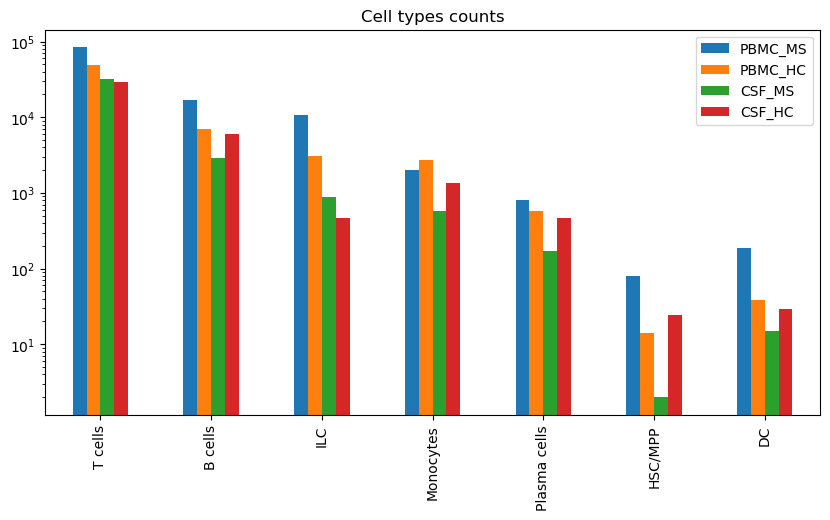

In [11]:
cell_labels_counts_df.plot(kind='bar', figsize=(10, 5), title='Cell types counts', logy=True);

## Rank genes groups

In [12]:
def compute_rank_genes_group(adata_cell_type, methods=['t-test', 'wilcoxon']):
    # compare each group to the union of the rest of the groups, so MS vs HC
    sc.tl.rank_genes_groups(adata_cell_type, 'MS/HC', random_state=RANDOM_STATE)

    for metohd in methods:
        print(f'Computing rank_genes_groups for {metohd}')
        sc.tl.rank_genes_groups(adata_cell_type, 'MS/HC', method=metohd, key_added=metohd, random_state=RANDOM_STATE)

    return adata_cell_type

### T cells

In [13]:
if os.path.exists('write/T_cells.h5ad'):
    adata_T_cells = sc.read('write/T_cells.h5ad')
else:
    adata_T_cells = adata[adata.obs['cell_types_labels']=='T cells']
    adata_T_cells = compute_rank_genes_group(adata_T_cells)
    adata_T_cells.write('write/T_cells.h5ad')

In [14]:
adata_T_cells

AnnData object with n_obs × n_vars = 193689 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

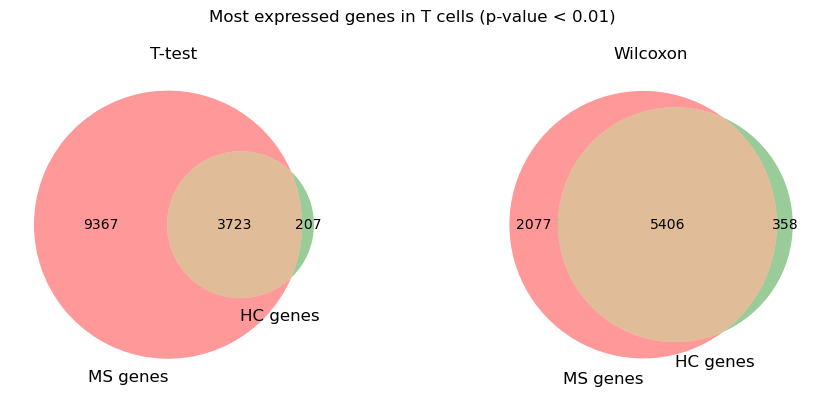

In [15]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_T_cells, cell_type_name='T cells')

All write reported below are for the Wilcoxon test.

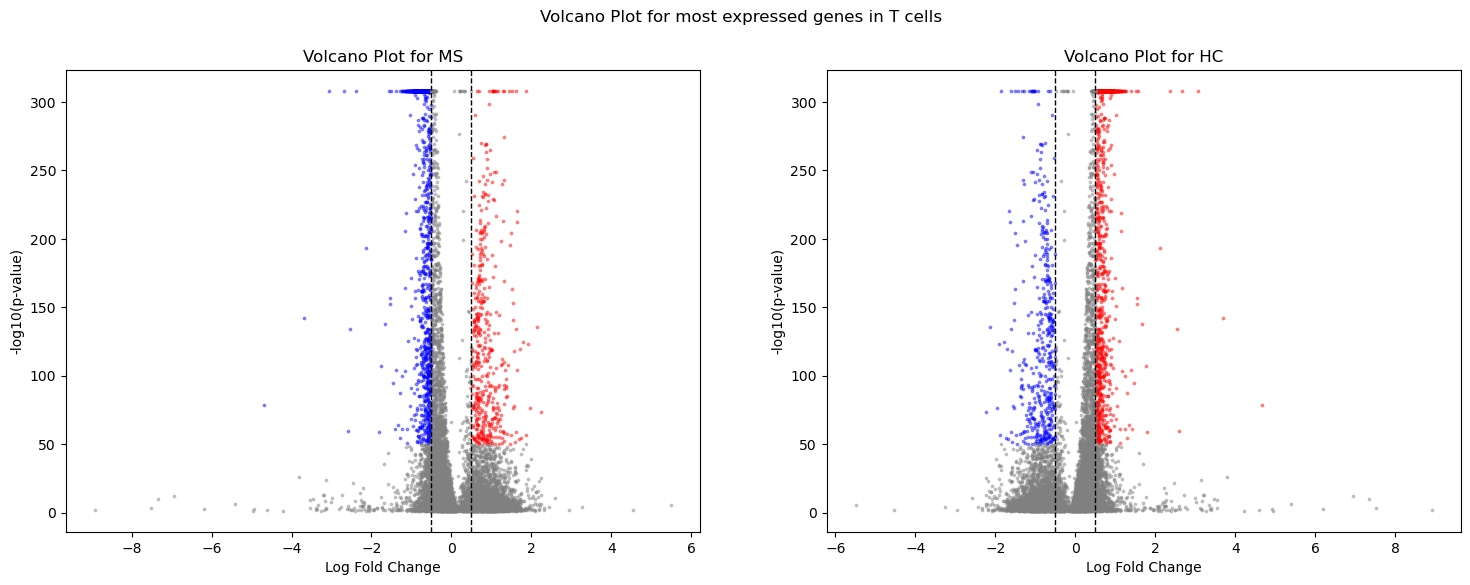

In [16]:
volcano_plot(adata_T_cells, cell_type_name='T cells')

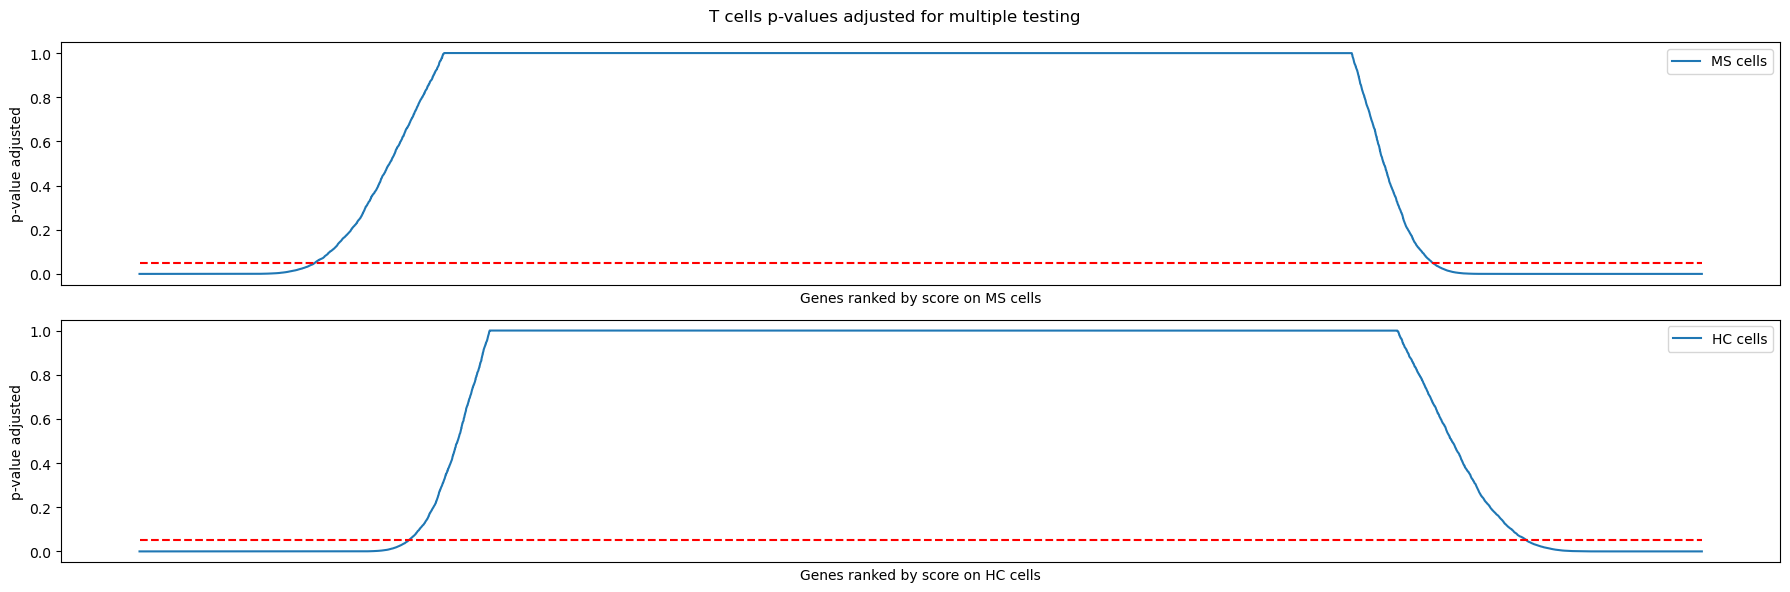

In [17]:
visualize_p_value_adj(adata_T_cells, cell_type_name='T cells')

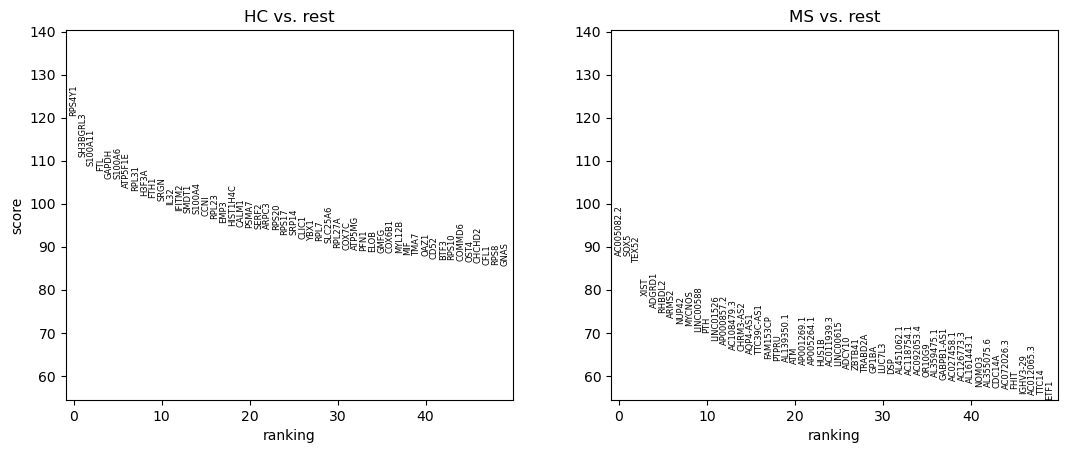

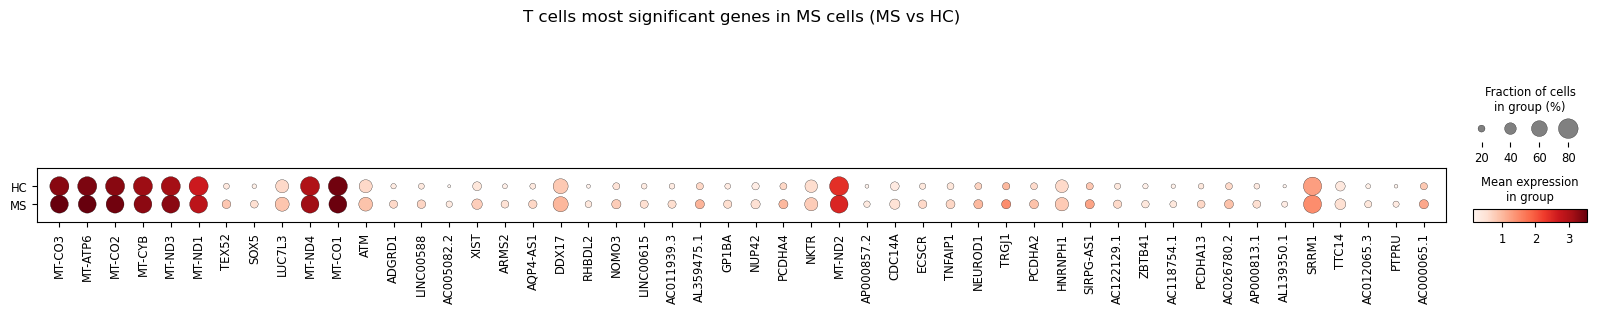

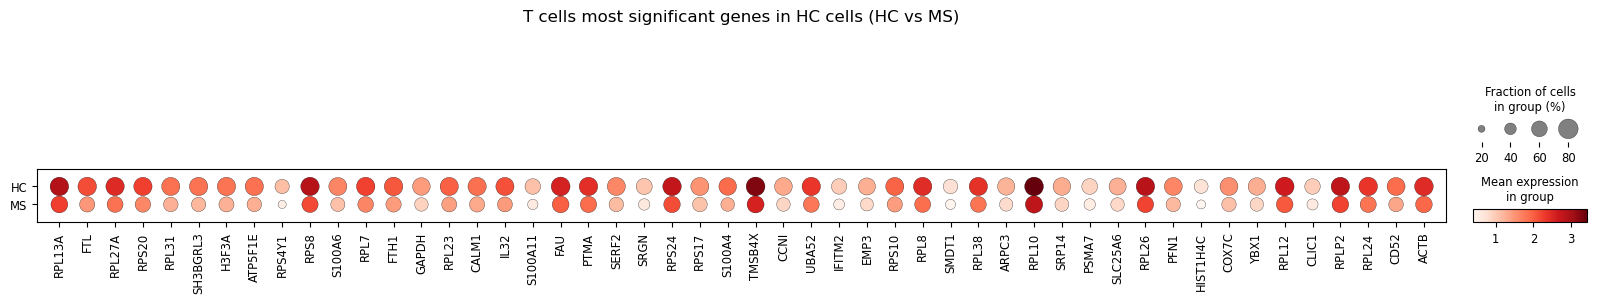

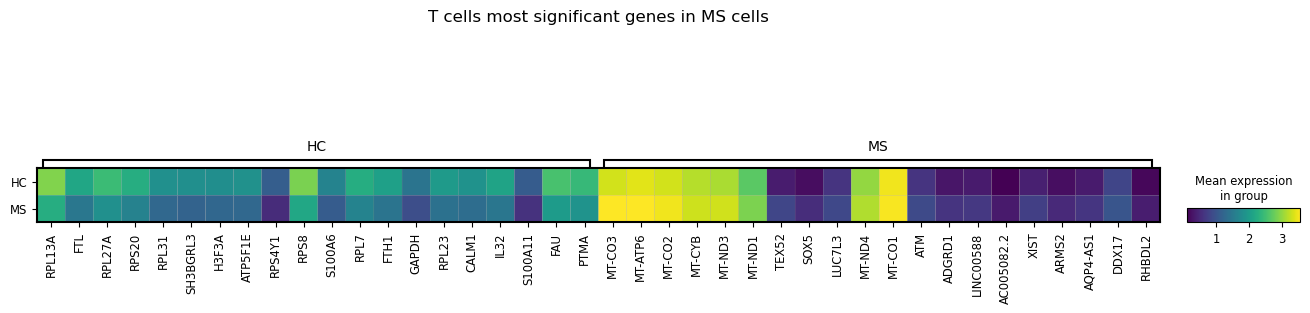

In [18]:
dotplots_and_ranking_most_significant_genes(adata_T_cells, cell_type_name='T cells')

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



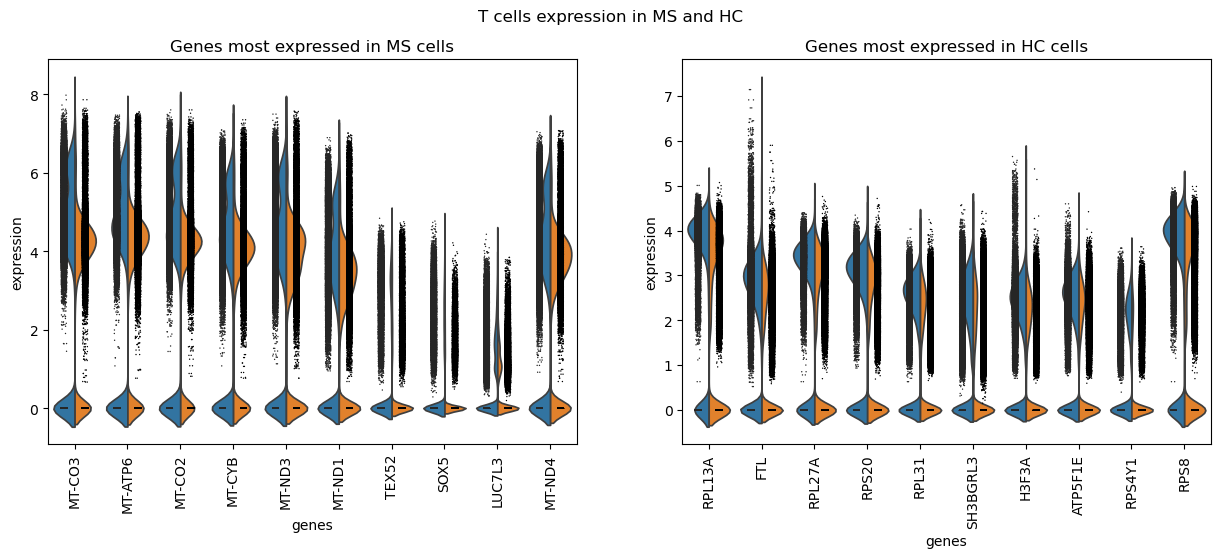

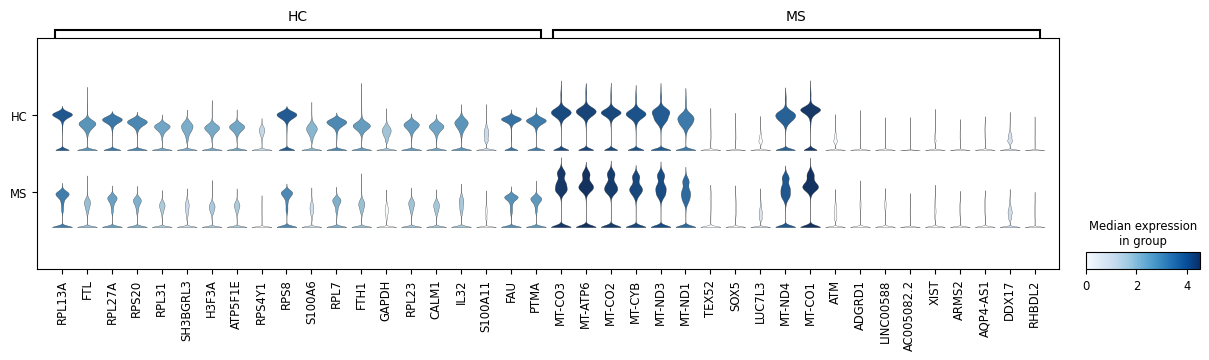

In [19]:
visualize_rank_genes_groups_violin(adata_T_cells, cell_type_name='T cells')

In [20]:
sc.get.rank_genes_groups_df(adata_T_cells, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  9694.000000     9694.000000  9.694000e+03  9.694000e+03
mean      7.310610       -0.058408  1.112970e-04  4.541008e-04
std      18.889601        0.726950  3.702746e-04  1.480467e-03
min     -71.969009       -5.495568  0.000000e+00  0.000000e+00
25%      -4.740997       -0.673720  2.307855e-63  3.612185e-62
50%       5.129857        0.155909  9.455760e-17  7.401526e-16
75%      13.798547        0.444122  8.372020e-07  4.369121e-06
max     121.225281        7.509241  2.548809e-03  9.976482e-03

In [21]:
sum(adata_T_cells.uns['wilcoxon']['pvals_adj']['HC'] < 0.01) / len(adata_T_cells.uns['wilcoxon']['pvals_adj']['HC'])

0.2554817625975121

In [22]:
sc.get.rank_genes_groups_df(adata_T_cells, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  9694.000000     9694.000000  9.694000e+03  9.694000e+03
mean     -7.310609        0.058408  1.112970e-04  4.541008e-04
std      18.889601        0.726950  3.702746e-04  1.480467e-03
min    -121.225281       -7.509241  0.000000e+00  0.000000e+00
25%     -13.798547       -0.444122  2.307855e-63  3.612185e-62
50%      -5.129857       -0.155909  9.455760e-17  7.401526e-16
75%       4.740997        0.673720  8.372020e-07  4.369121e-06
max      71.969009        5.495568  2.548809e-03  9.976482e-03

In [23]:
sum(adata_T_cells.uns['wilcoxon']['pvals_adj']['MS'] < 0.01) / len(adata_T_cells.uns['wilcoxon']['pvals_adj']['MS'])

0.2554817625975121

### B cells

In [24]:
if os.path.exists('write/B_cells.h5ad'):
    adata_B_cells = sc.read('write/B_cells.h5ad')
else:
    adata_B_cells = adata[adata.obs['cell_types_labels']=='B cells']
    adata_B_cells = compute_rank_genes_group(adata_B_cells)
    adata_B_cells.write('write/B_cells.h5ad')
adata_B_cells

AnnData object with n_obs × n_vars = 32879 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

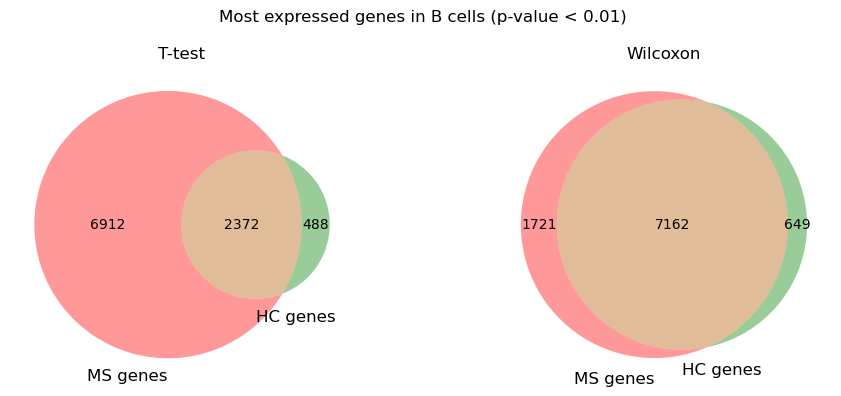

In [25]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_B_cells, cell_type_name='B cells')

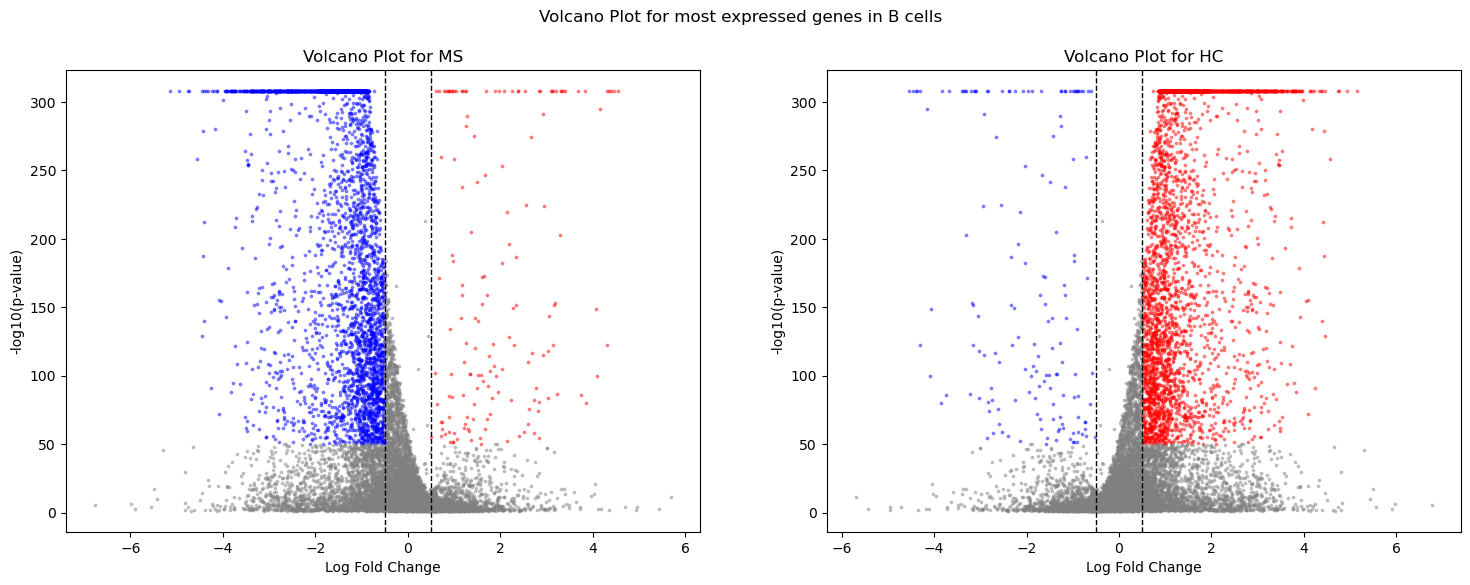

In [26]:
volcano_plot(adata_B_cells, cell_type_name='B cells')

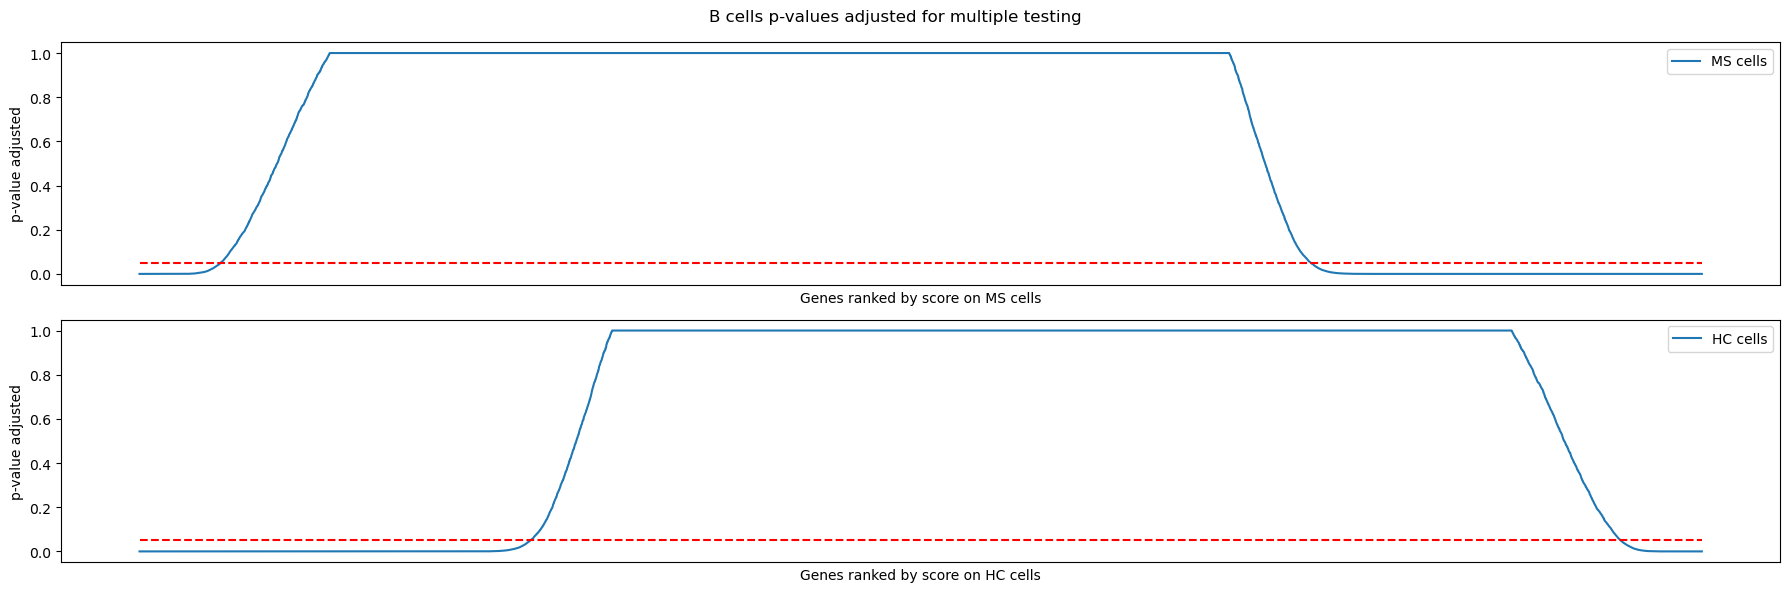

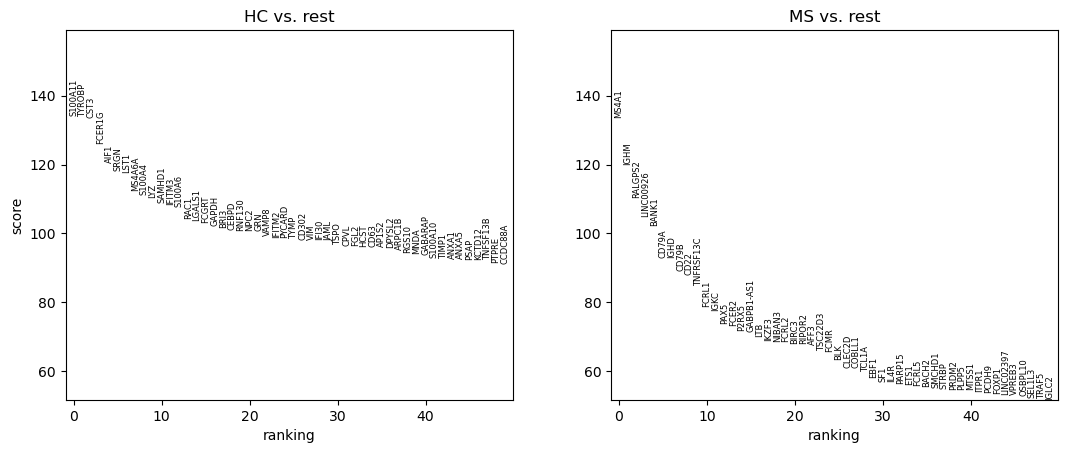

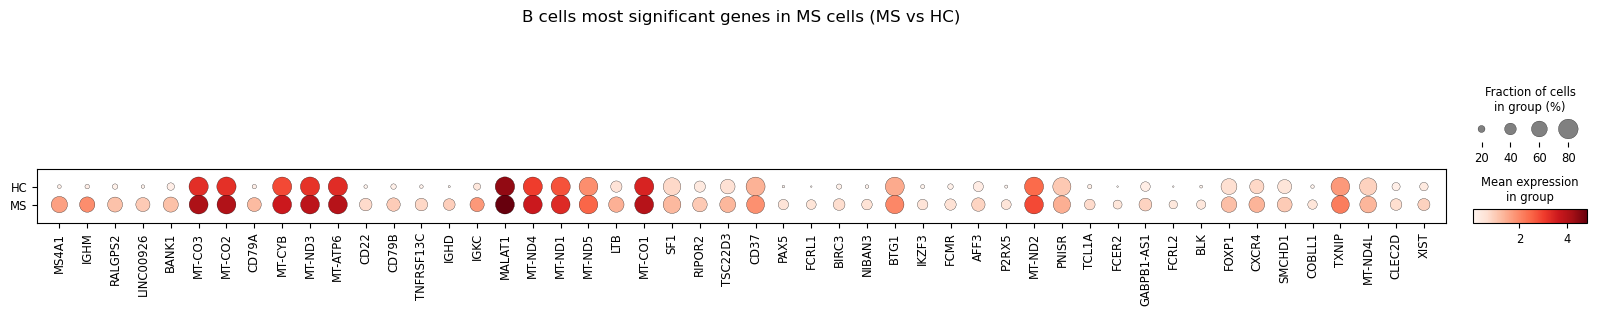

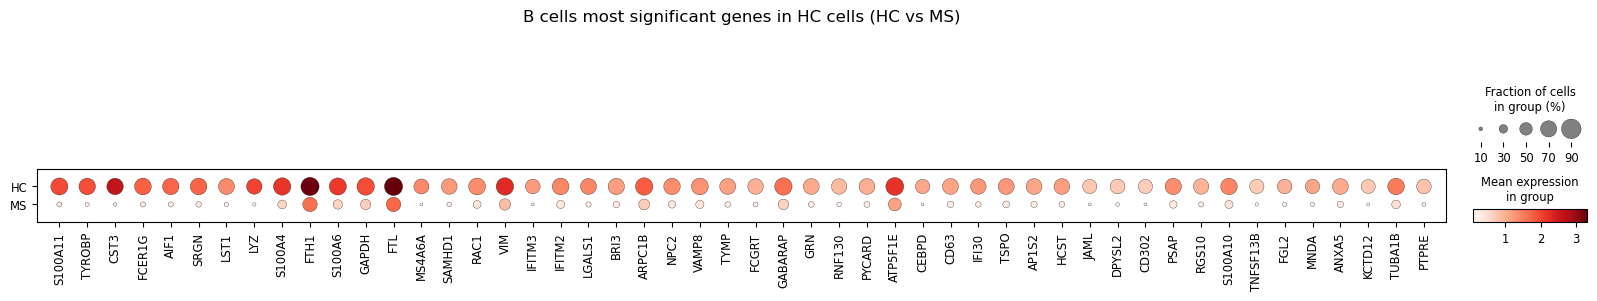

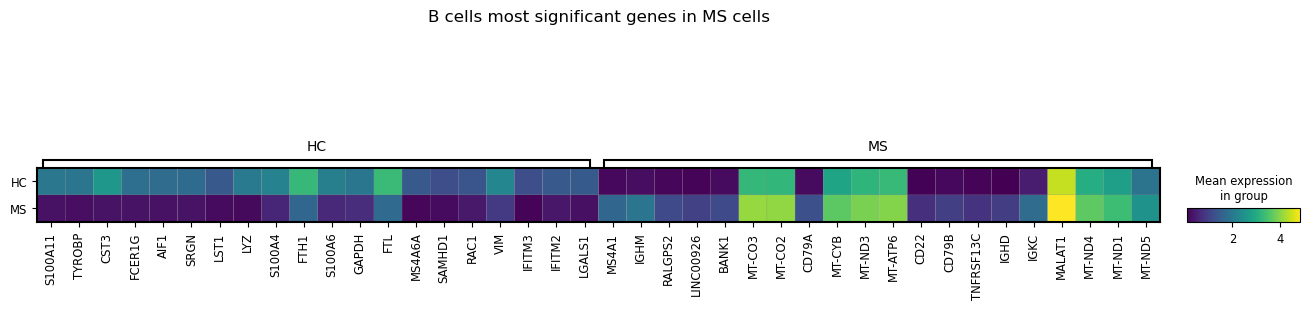

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



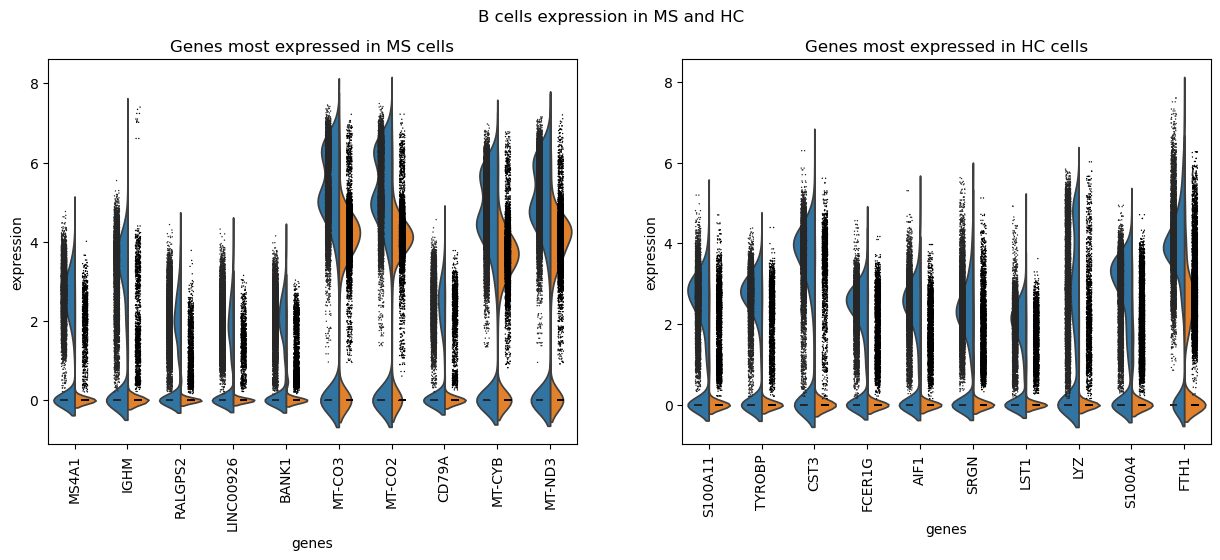

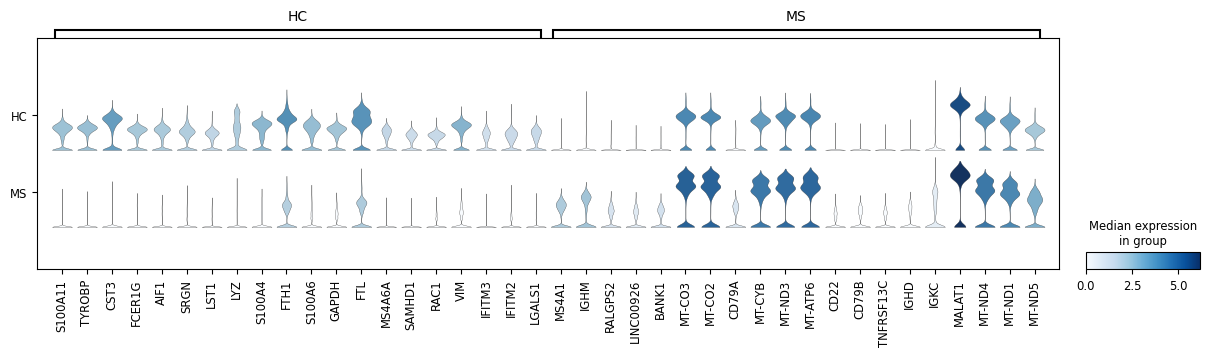

In [27]:
visualize_p_value_adj(adata_B_cells, cell_type_name='B cells')
dotplots_and_ranking_most_significant_genes(adata_B_cells, cell_type_name='B cells')
visualize_rank_genes_groups_violin(adata_B_cells, cell_type_name='B cells')

In [28]:
sc.get.rank_genes_groups_df(adata_B_cells, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  10671.000000    10671.000000   1.067100e+04   1.067100e+04
mean      14.675193        0.583465   9.140960e-05   3.348979e-04
std       17.587250        1.152781   3.582197e-04   1.294487e-03
min      -86.649330       -5.696106   0.000000e+00   0.000000e+00
25%        4.676613       -0.049119  1.963292e-119  2.791628e-118
50%       10.876610        0.548457   4.997040e-31   3.553367e-30
75%       22.651141        1.182618   3.525918e-09   1.671611e-08
max       99.651894        6.772264   2.792864e-03   9.930882e-03

In [29]:
sc.get.rank_genes_groups_df(adata_B_cells, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  10671.000000    10671.000000   1.067100e+04   1.067100e+04
mean     -14.675193       -0.583465   9.140960e-05   3.348979e-04
std       17.587250        1.152781   3.582197e-04   1.294487e-03
min      -99.651894       -6.772264   0.000000e+00   0.000000e+00
25%      -22.651141       -1.182618  1.963292e-119  2.791628e-118
50%      -10.876610       -0.548457   4.997040e-31   3.553367e-30
75%       -4.676613        0.049119   3.525918e-09   1.671611e-08
max       86.649330        5.696106   2.792864e-03   9.930882e-03

### ILC

In [30]:
if os.path.exists('write/ILC.h5ad'):
    adata_ILC = sc.read('write/ILC.h5ad')
else:
    adata_ILC = adata[adata.obs['cell_types_labels']=='ILC']
    adata_ILC = compute_rank_genes_group(adata_ILC)
    adata_ILC.write('write/ILC.h5ad')
adata_ILC

AnnData object with n_obs × n_vars = 15136 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

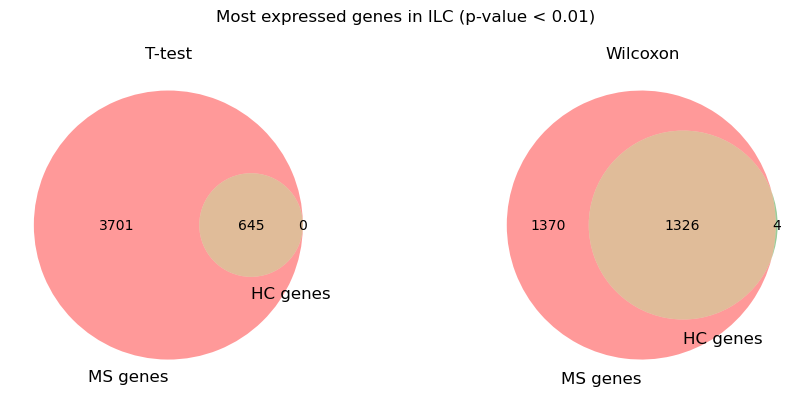

In [31]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_ILC, cell_type_name='ILC')

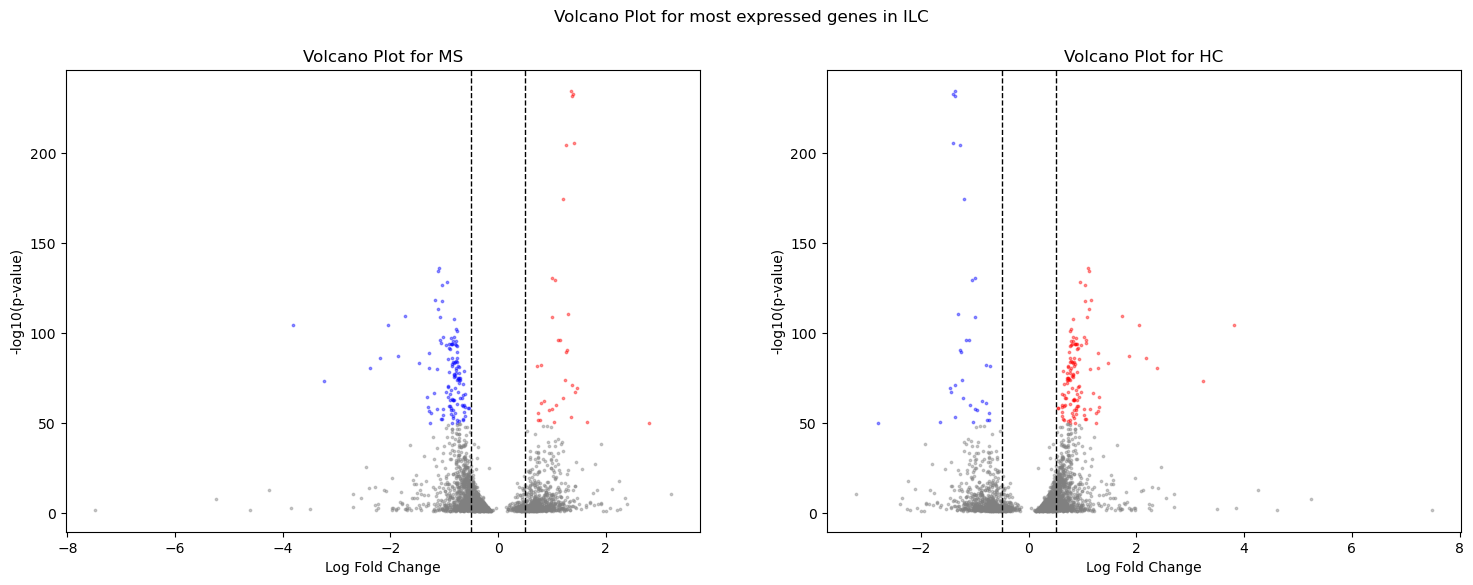

In [32]:
volcano_plot(adata_ILC, cell_type_name='ILC')

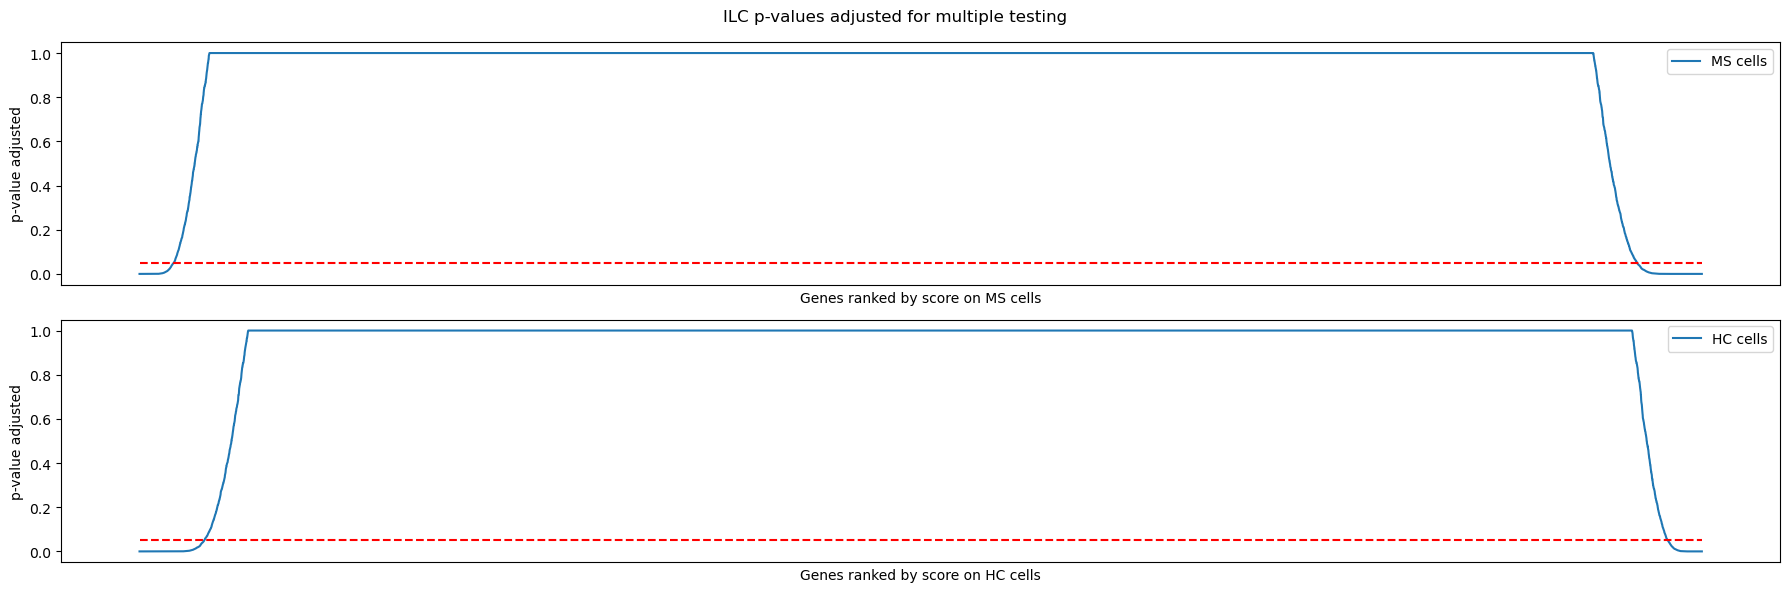

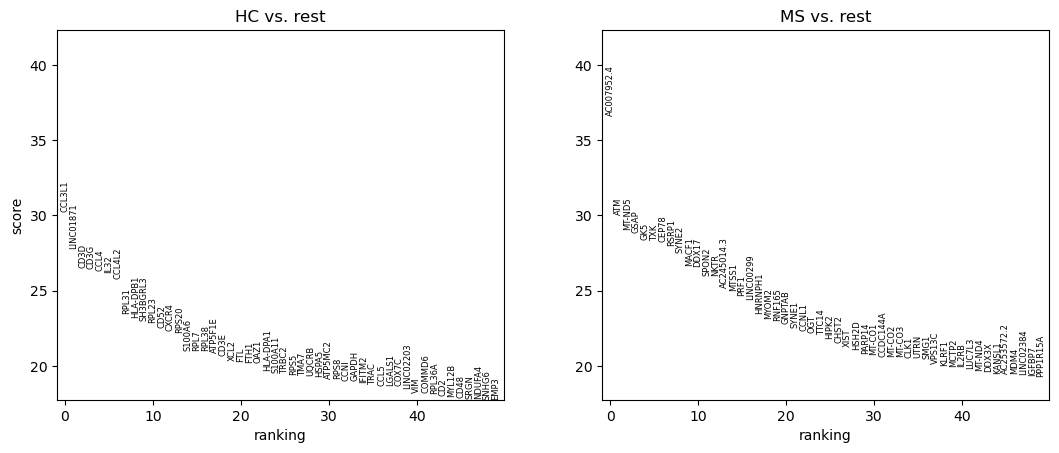

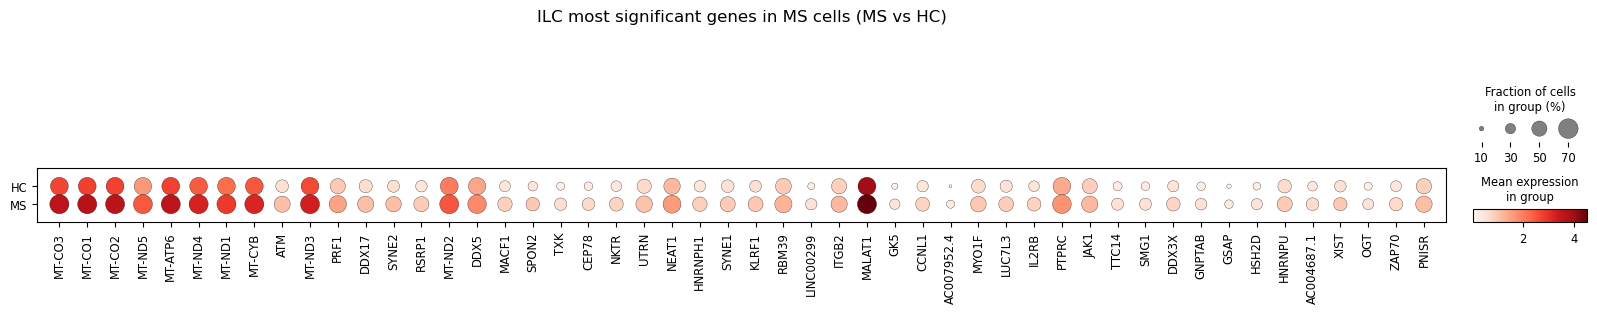

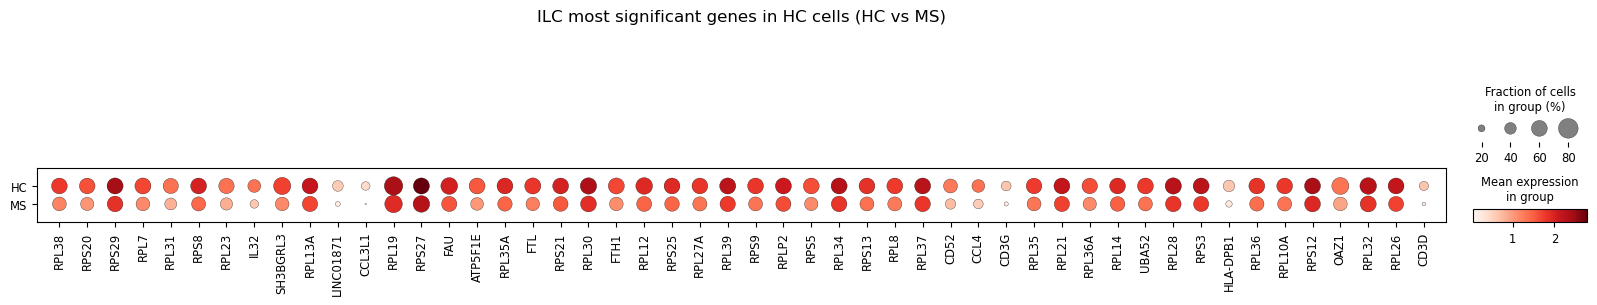

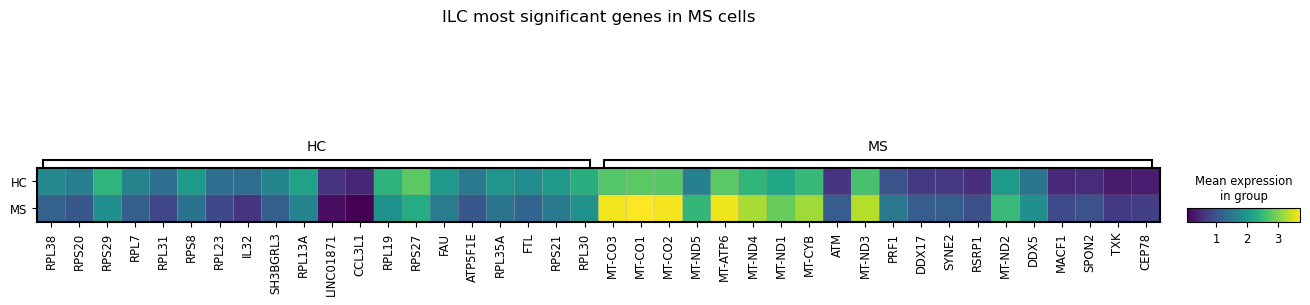

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



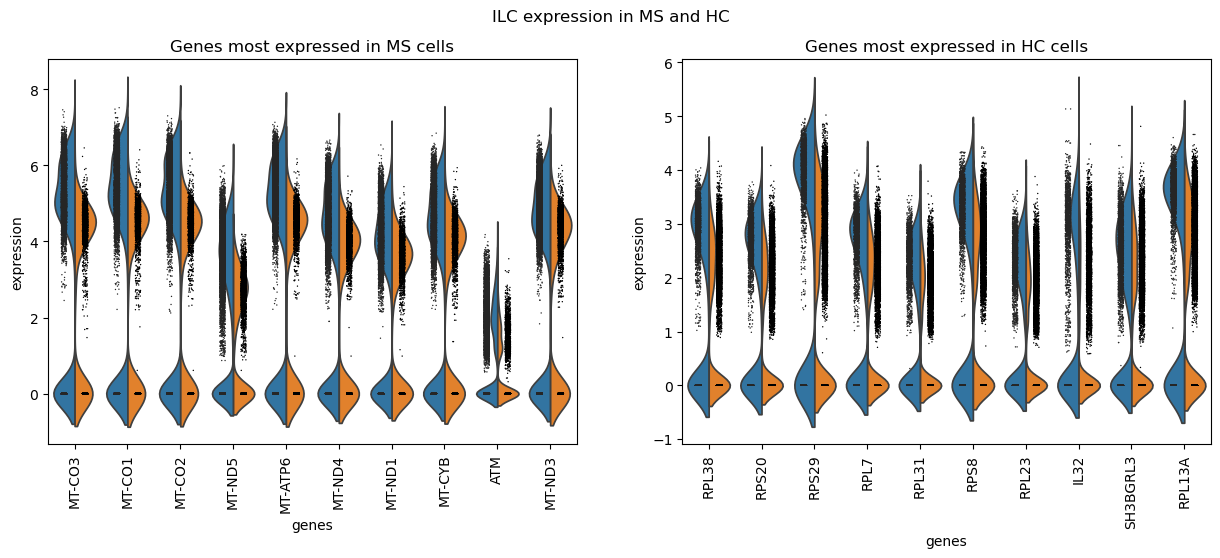

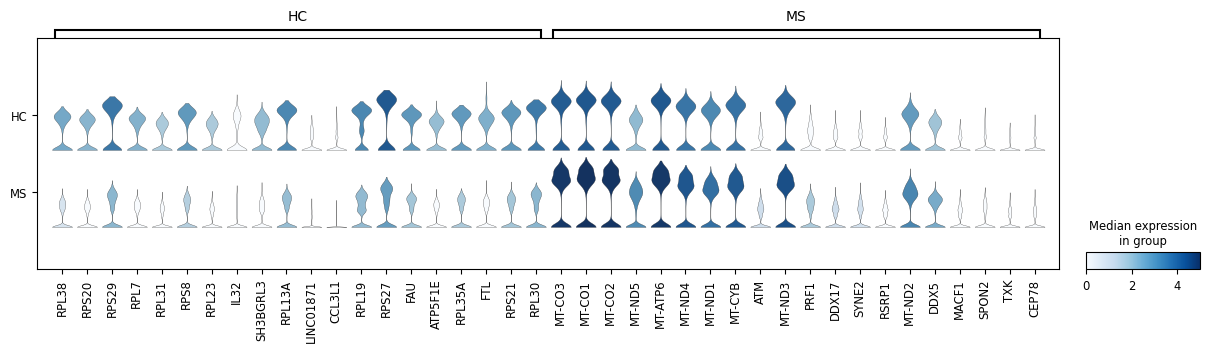

In [33]:
visualize_p_value_adj(adata_ILC, cell_type_name='ILC')
dotplots_and_ranking_most_significant_genes(adata_ILC, cell_type_name='ILC')
visualize_rank_genes_groups_violin(adata_ILC, cell_type_name='ILC')

In [34]:
sc.get.rank_genes_groups_df(adata_ILC, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  1975.000000     1975.000000   1.975000e+03   1.975000e+03
mean      2.919027        0.156275   4.076085e-05   8.429840e-04
std       8.068620        0.780425   1.004538e-04   1.998923e-03
min     -33.069683       -3.213086  8.110305e-240  3.077374e-235
25%      -4.131700       -0.569548   1.653852e-17   1.269019e-15
50%       4.550758        0.405678   9.009028e-09   3.459905e-07
75%       7.166497        0.623743   1.278222e-05   3.273766e-04
max      25.233599        5.239149   5.197443e-04   9.985406e-03

In [35]:
sc.get.rank_genes_groups_df(adata_ILC, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  1975.000000     1975.000000   1.975000e+03   1.975000e+03
mean     -2.919027       -0.156275   4.076085e-05   8.429840e-04
std       8.068620        0.780425   1.004538e-04   1.998923e-03
min     -25.233599       -5.239149  8.110305e-240  3.077374e-235
25%      -7.166497       -0.623743   1.653852e-17   1.269019e-15
50%      -4.550758       -0.405678   9.009028e-09   3.459905e-07
75%       4.131700        0.569548   1.278222e-05   3.273766e-04
max      33.069683        3.213086   5.197443e-04   9.985406e-03

### Monocytes

In [36]:
if os.path.exists('write/Monocytes.h5ad'):
    adata_Monocytes = sc.read('write/Monocytes.h5ad')
else:
    adata_Monocytes = adata[adata.obs['cell_types_labels']=='Monocytes']
    adata_Monocytes = compute_rank_genes_group(adata_Monocytes)
    adata_Monocytes.write('write/Monocytes.h5ad')
adata_Monocytes

AnnData object with n_obs × n_vars = 6649 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

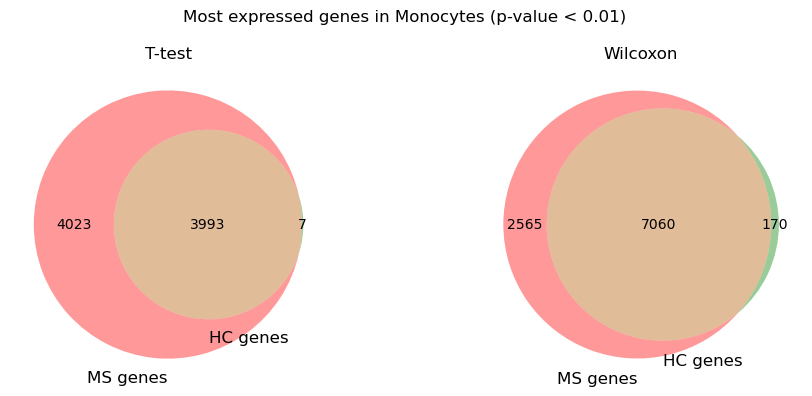

In [37]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_Monocytes, cell_type_name='Monocytes')

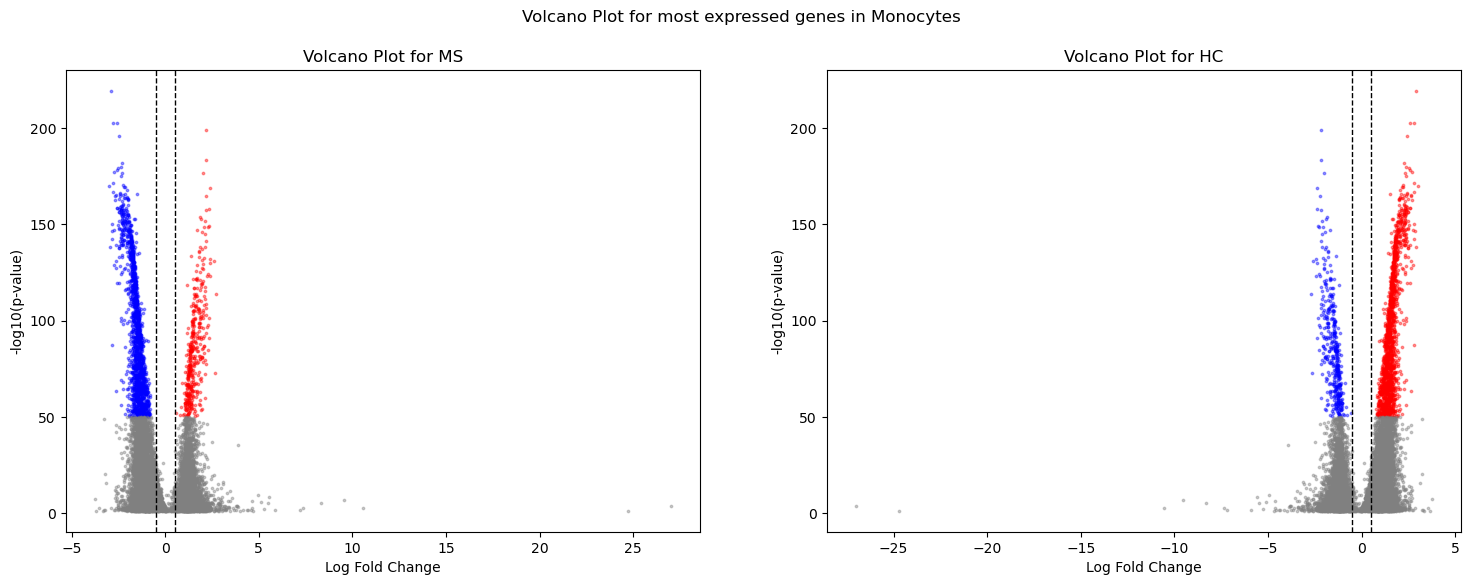

In [38]:
volcano_plot(adata_Monocytes, cell_type_name='Monocytes')

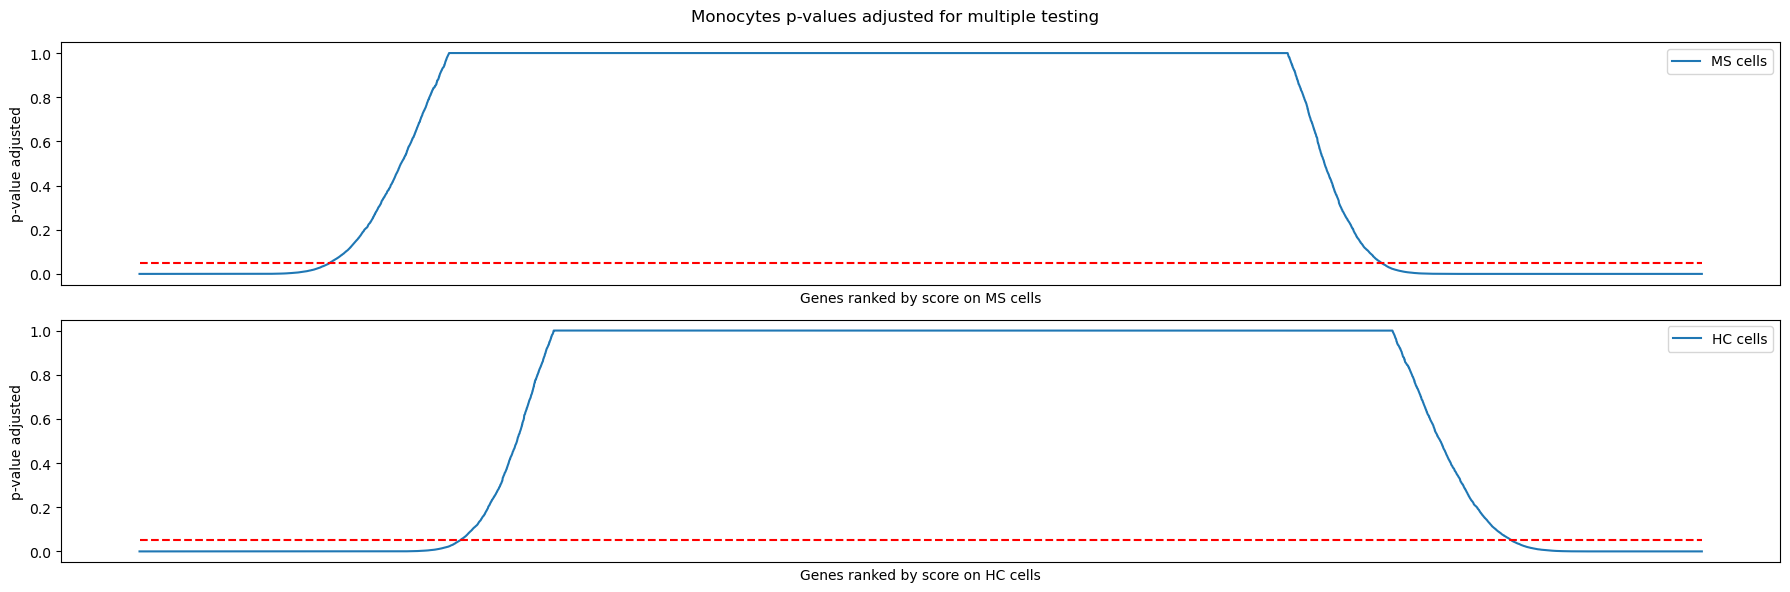

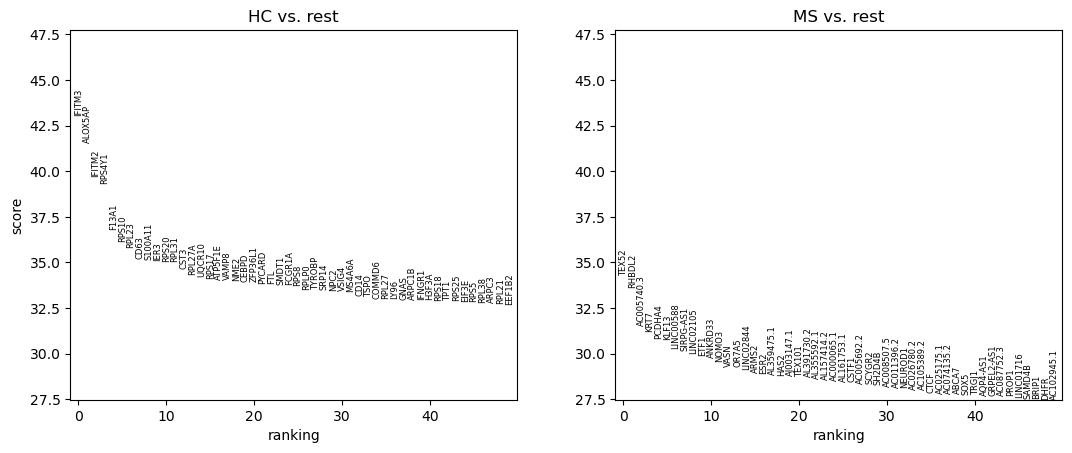

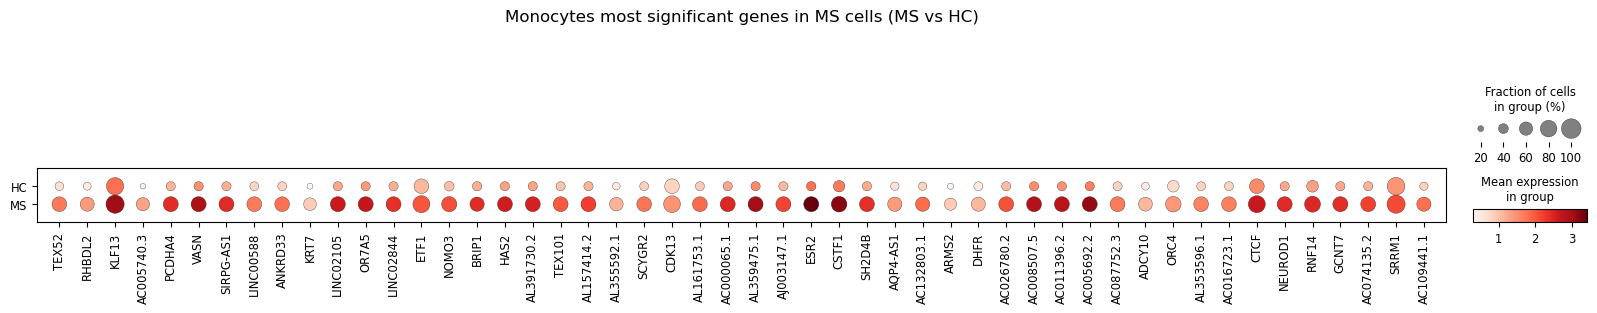

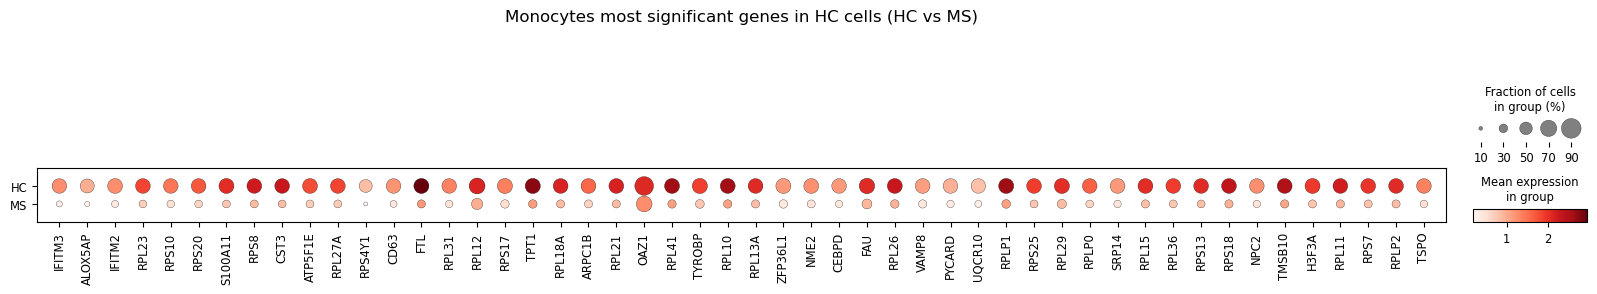

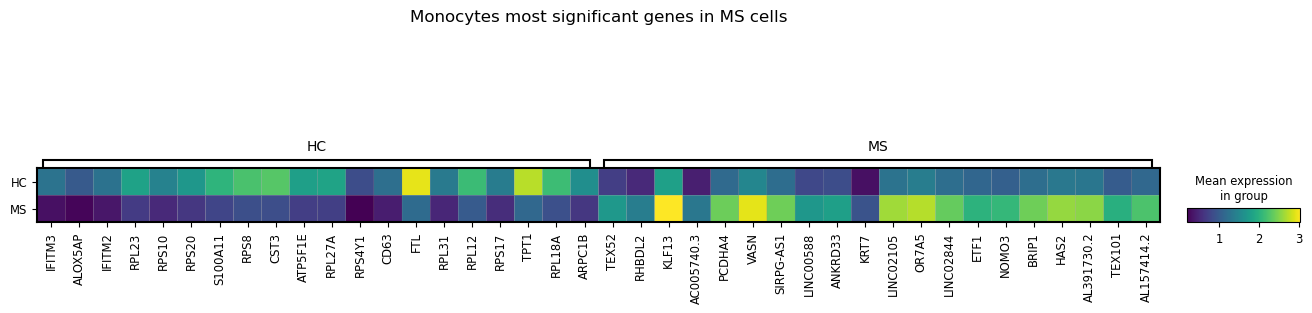

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



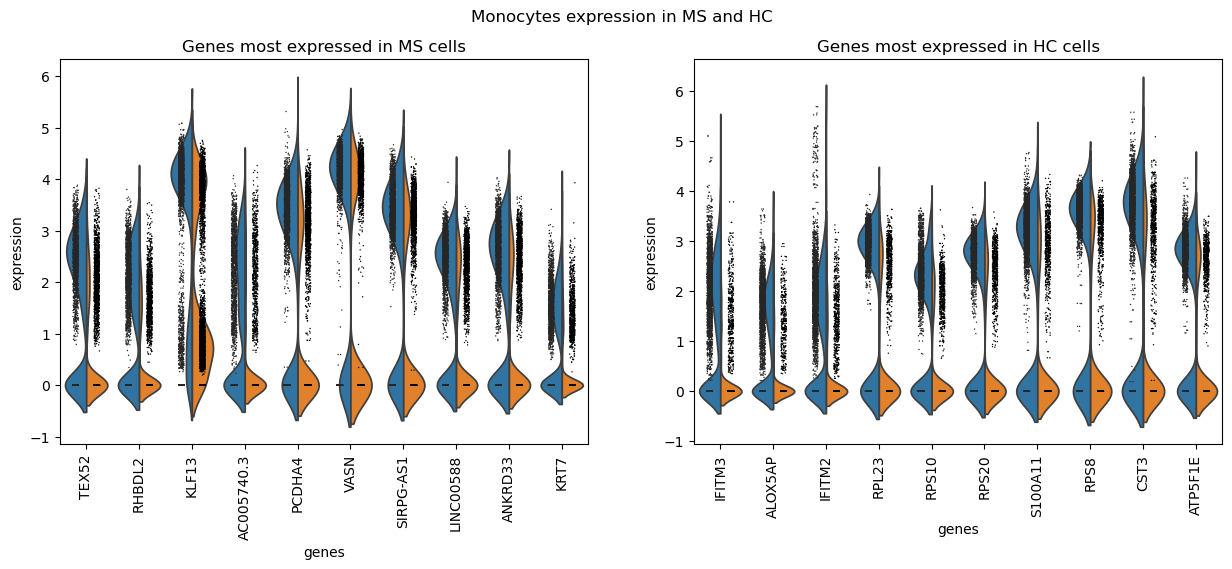

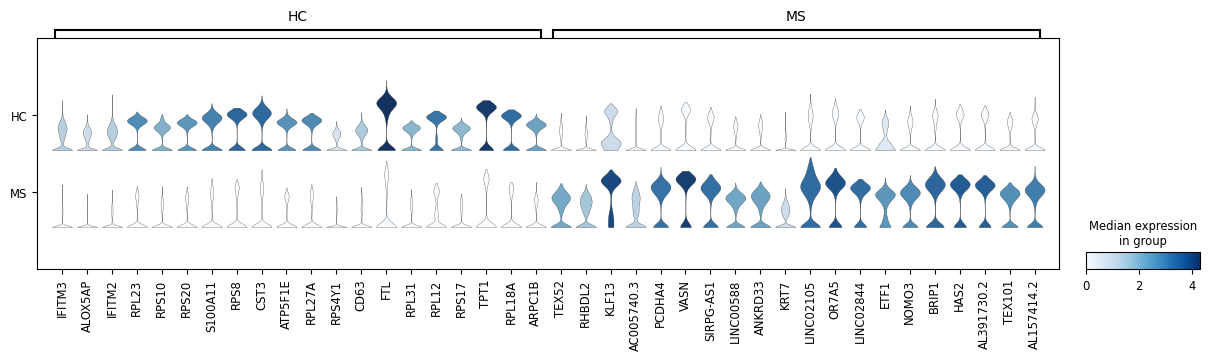

In [39]:
visualize_p_value_adj(adata_Monocytes, cell_type_name='Monocytes')
dotplots_and_ranking_most_significant_genes(adata_Monocytes, cell_type_name='Monocytes')
visualize_rank_genes_groups_violin(adata_Monocytes, cell_type_name='Monocytes')

In [40]:
sc.get.rank_genes_groups_df(adata_Monocytes, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  11230.000000    11230.000000   1.123000e+04   1.123000e+04
mean       4.033996        0.300275   1.415634e-04   4.999662e-04
std       10.624386        1.328812   4.547190e-04   1.571916e-03
min      -30.452003      -27.029097  1.110257e-224  4.212760e-220
25%       -4.416091       -1.082849   2.440770e-38   3.297875e-37
50%        5.132256        0.883701   2.920899e-14   1.973654e-13
75%       10.965678        1.334660   1.625731e-06   7.323824e-06
max       31.999437        3.763093   2.956970e-03   9.991030e-03

In [41]:
sc.get.rank_genes_groups_df(adata_Monocytes, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  11230.000000    11230.000000   1.123000e+04   1.123000e+04
mean      -4.033996       -0.300275   1.415634e-04   4.999662e-04
std       10.624386        1.328812   4.547190e-04   1.571916e-03
min      -31.999437       -3.763093  1.110257e-224  4.212760e-220
25%      -10.965678       -1.334660   2.440770e-38   3.297875e-37
50%       -5.132256       -0.883701   2.920899e-14   1.973654e-13
75%        4.416091        1.082849   1.625731e-06   7.323824e-06
max       30.452003       27.029097   2.956970e-03   9.991030e-03

### Plasma cells

In [42]:
if os.path.exists('results/plasma_cells.h5ad'):
    adata_plasma_cells = sc.read('write/plasma_cells.h5ad')
else:
    adata_plasma_cells = adata[adata.obs['cell_types_labels']=='Plasma cells']
    adata_plasma_cells = compute_rank_genes_group(adata_plasma_cells)
    adata_plasma_cells.write('write/plasma_cells.h5ad')
adata_plasma_cells

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:640: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



Computing rank_genes_groups for t-test
Computing rank_genes_groups for wilcoxon


AnnData object with n_obs × n_vars = 2012 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

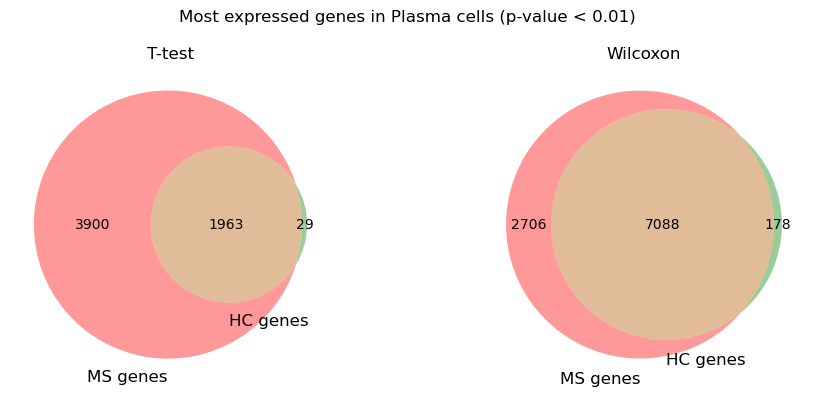

In [43]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_plasma_cells, cell_type_name='Plasma cells')

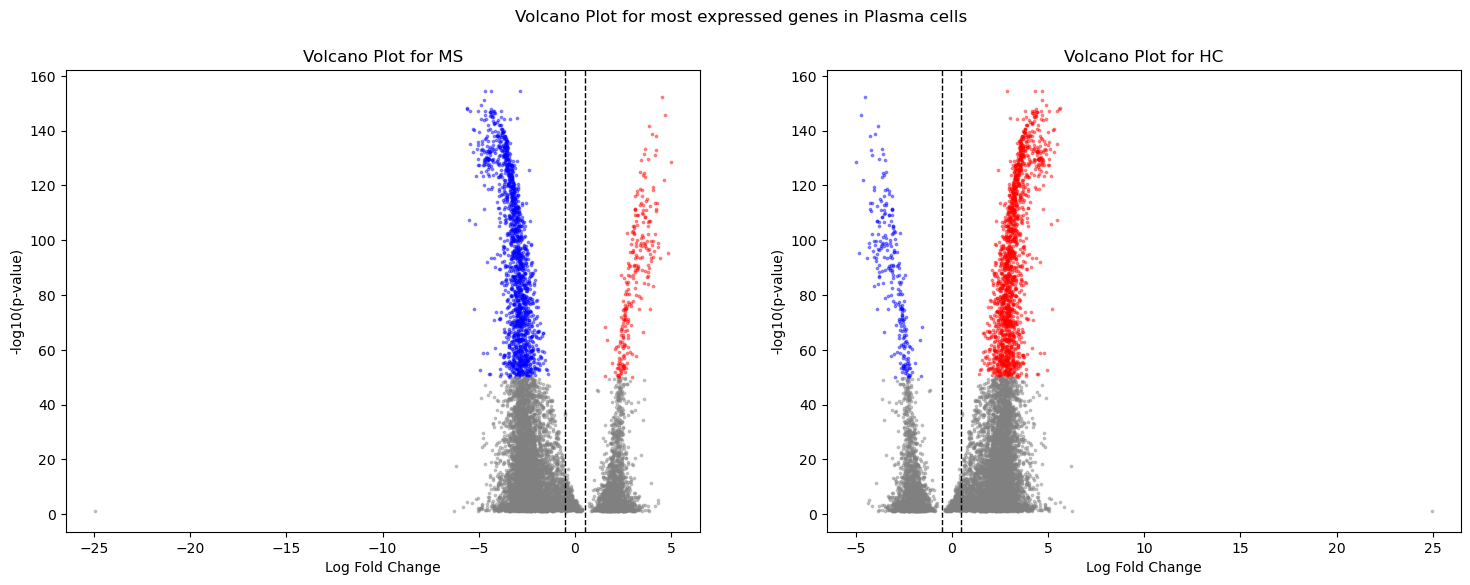

In [44]:
volcano_plot(adata_plasma_cells, cell_type_name='Plasma cells')

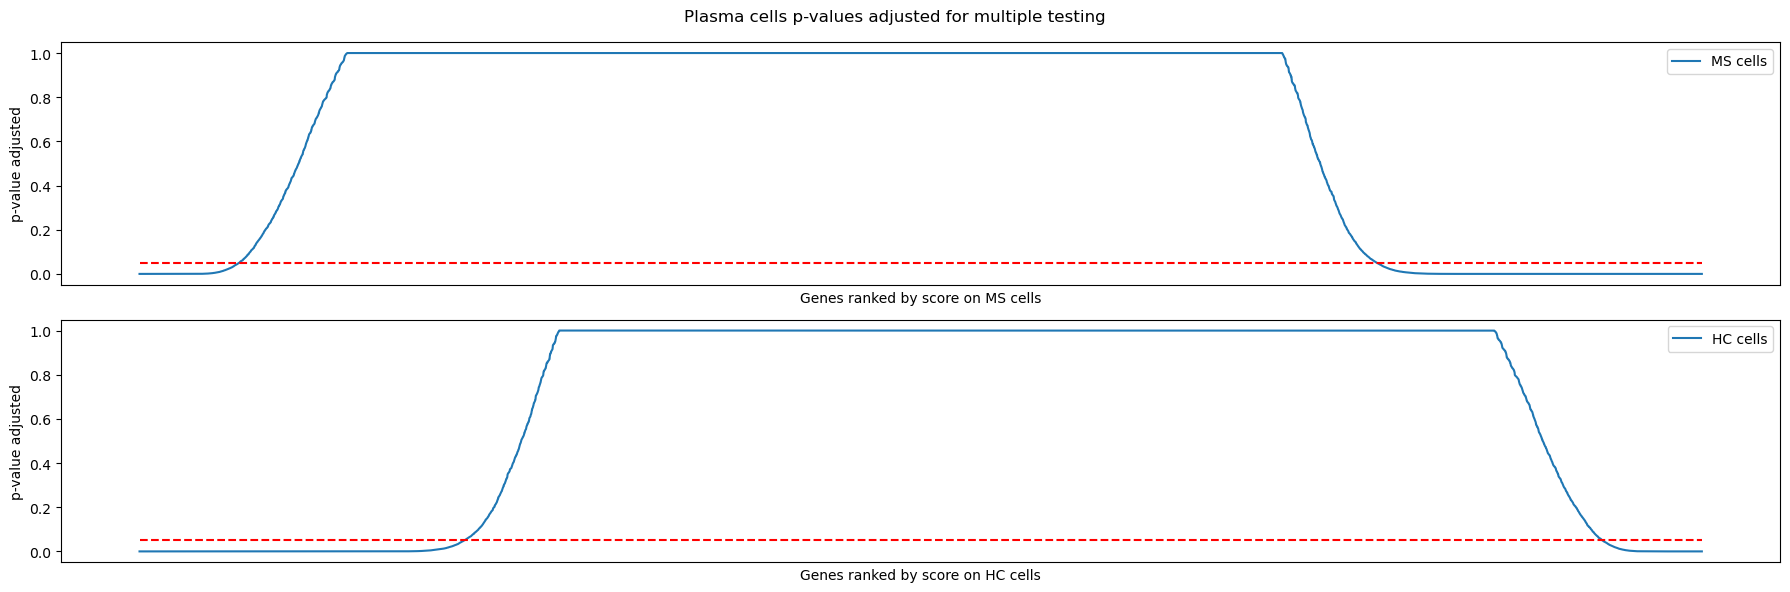

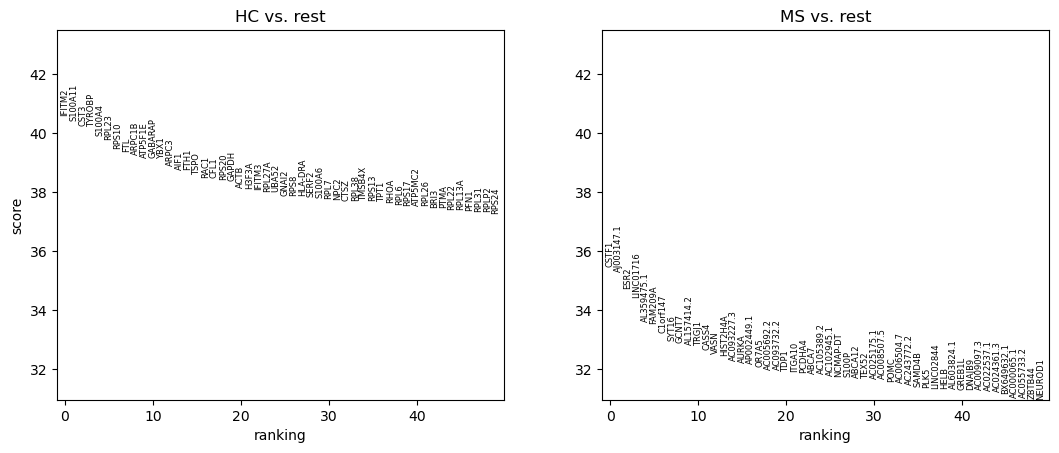

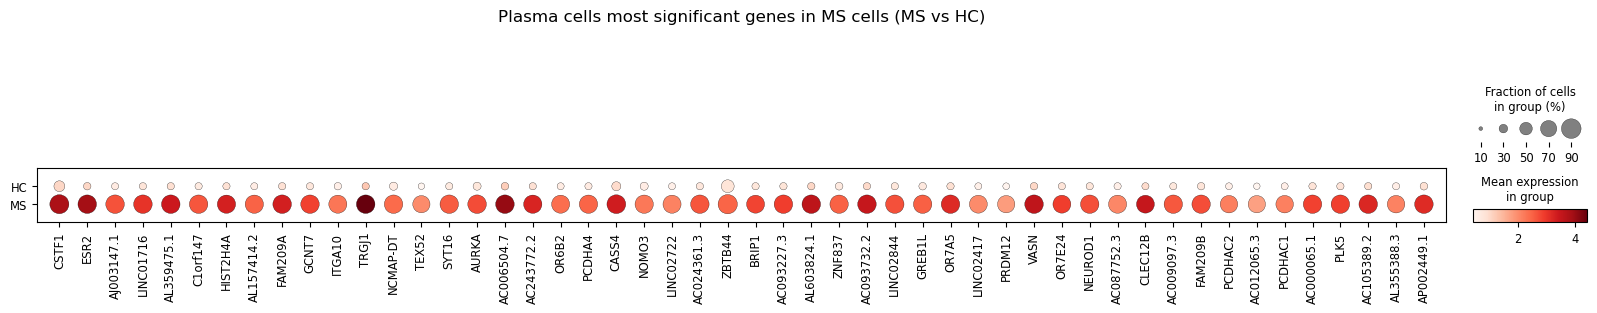

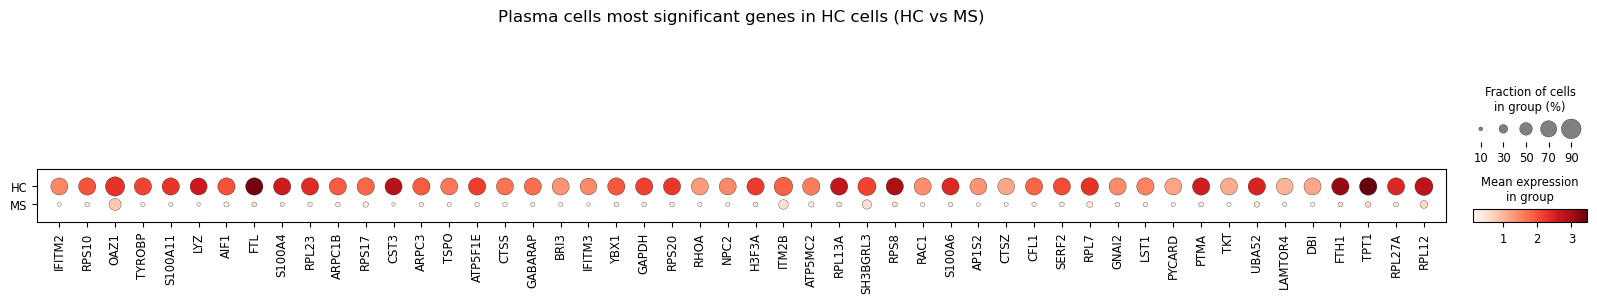

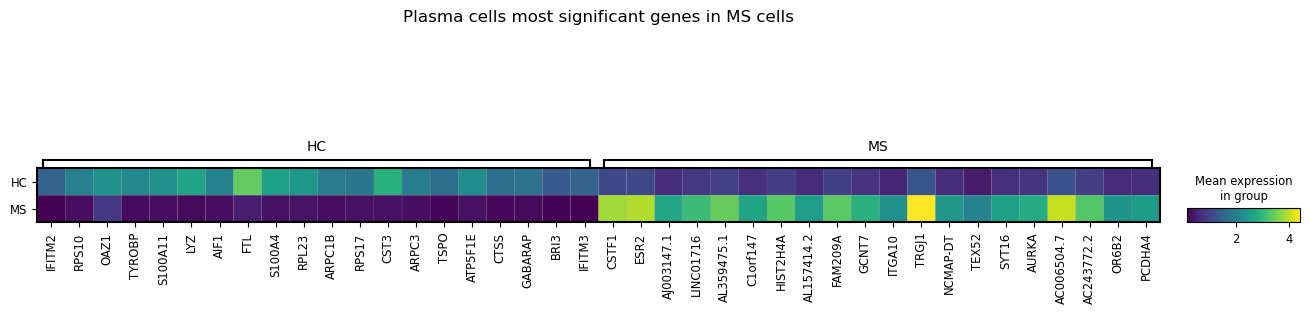

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



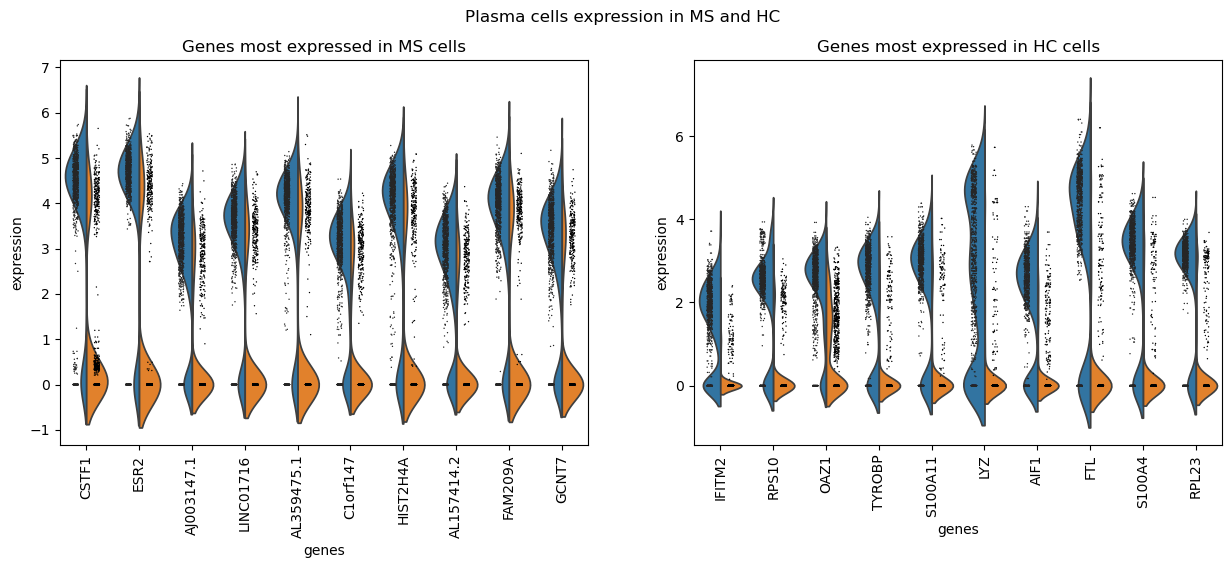

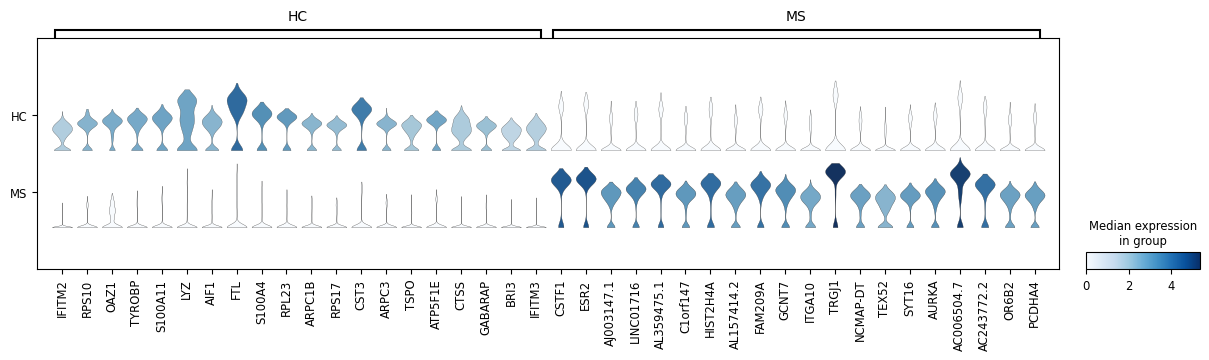

In [45]:
visualize_p_value_adj(adata_plasma_cells, cell_type_name='Plasma cells')
dotplots_and_ranking_most_significant_genes(adata_plasma_cells, cell_type_name='Plasma cells')
visualize_rank_genes_groups_violin(adata_plasma_cells, cell_type_name='Plasma cells')

In [46]:
sc.get.rank_genes_groups_df(adata_plasma_cells, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  9258.000000     9258.000000   9.258000e+03   9.258000e+03
mean      6.528630        1.479303   1.113256e-04   4.759456e-04
std       9.610785        2.077588   3.669805e-04   1.537207e-03
min     -26.680315       -5.002715  6.863299e-160  2.604210e-155
25%       3.402129        0.795010   3.929875e-41   6.440562e-40
50%       6.710077        2.302513   2.087822e-15   1.711206e-14
75%      12.388574        2.858044   1.006807e-06   5.501678e-06
max      26.943146        6.185398   2.439842e-03   9.999716e-03

In [47]:
sc.get.rank_genes_groups_df(adata_plasma_cells, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges          pvals      pvals_adj
count  9258.000000     9258.000000   9.258000e+03   9.258000e+03
mean     -6.528630       -1.479303   1.113256e-04   4.759456e-04
std       9.610785        2.077588   3.669805e-04   1.537207e-03
min     -26.943146       -6.185398  6.863299e-160  2.604210e-155
25%     -12.388574       -2.858044   3.929875e-41   6.440562e-40
50%      -6.710077       -2.302513   2.087822e-15   1.711206e-14
75%      -3.402129       -0.795010   1.006807e-06   5.501678e-06
max      26.680315        5.002715   2.439842e-03   9.999716e-03

### HSC/MPP

In [48]:
if os.path.exists('write/HSC/MPP.h5ad'):
    adata_HSC_MPP = sc.read('write/HSC_MPP.h5ad')
else:
    adata_HSC_MPP = adata[adata.obs['cell_types_labels']=='HSC/MPP']
    adata_HSC_MPP = compute_rank_genes_group(adata_HSC_MPP)
    adata_HSC_MPP.write('write/HSC_MPP.h5ad')
adata_HSC_MPP

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:640: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



Computing rank_genes_groups for t-test
Computing rank_genes_groups for wilcoxon


AnnData object with n_obs × n_vars = 121 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

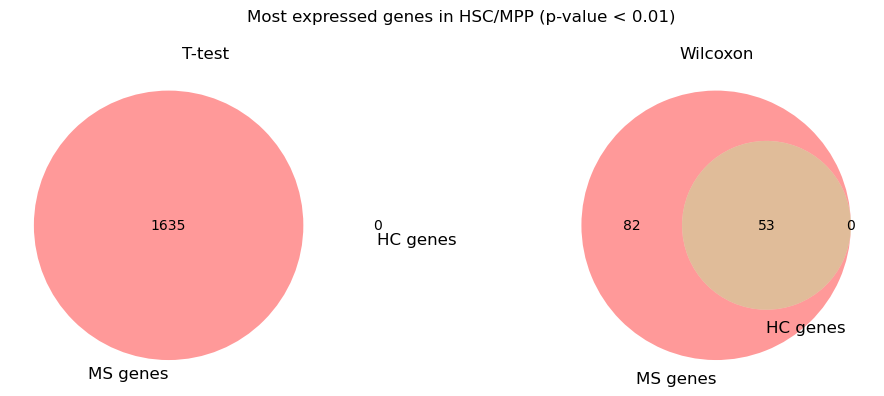

In [49]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_HSC_MPP, cell_type_name='HSC/MPP')

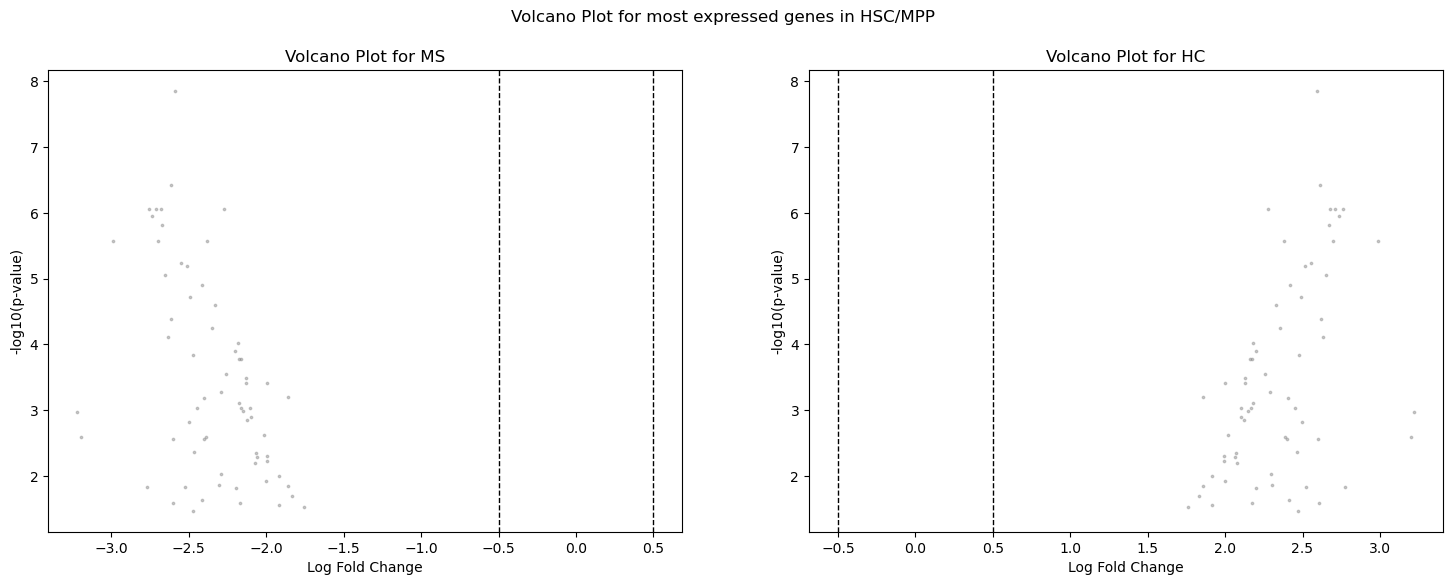

In [67]:
volcano_plot(adata_HSC_MPP, cell_type_name='HSC/MPP')

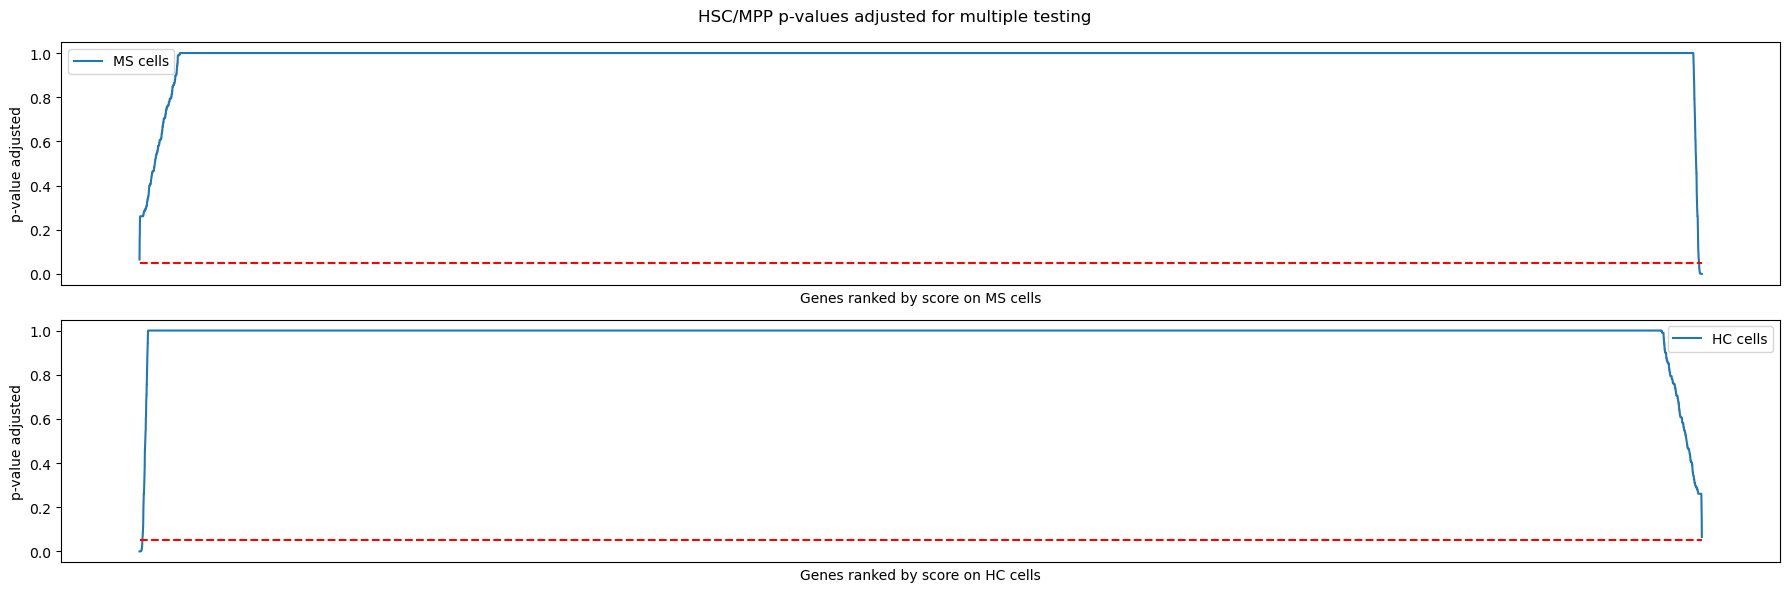

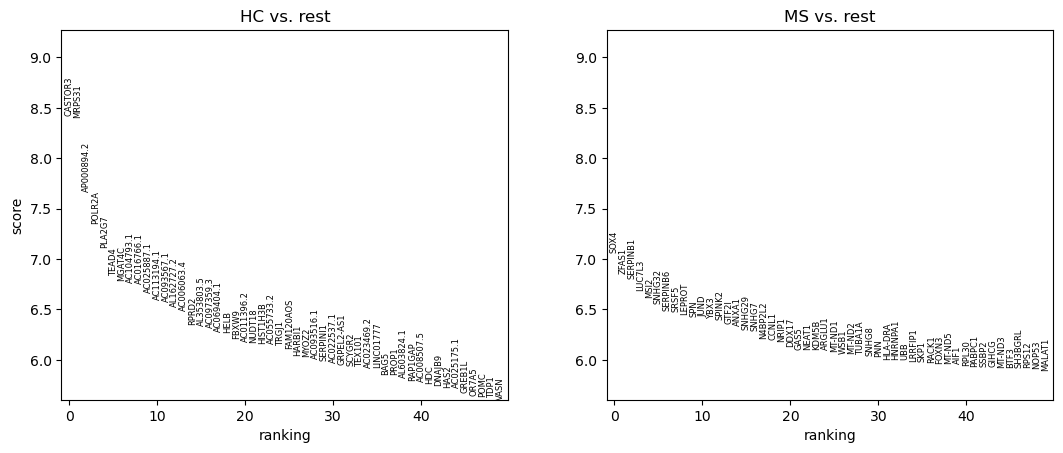

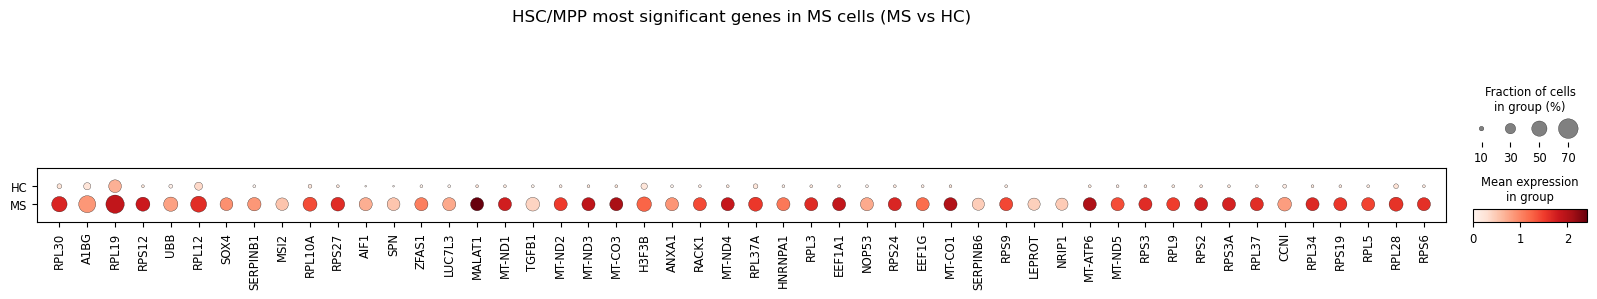

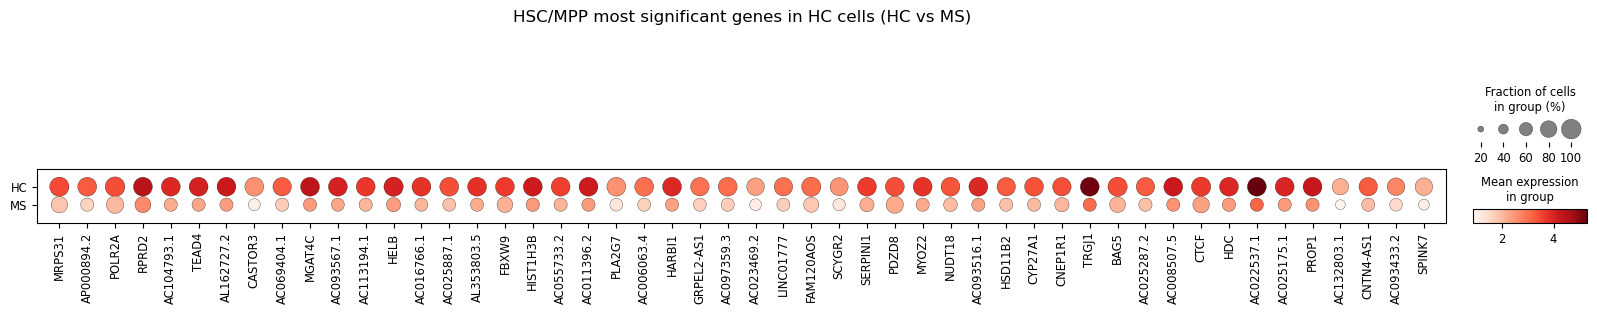

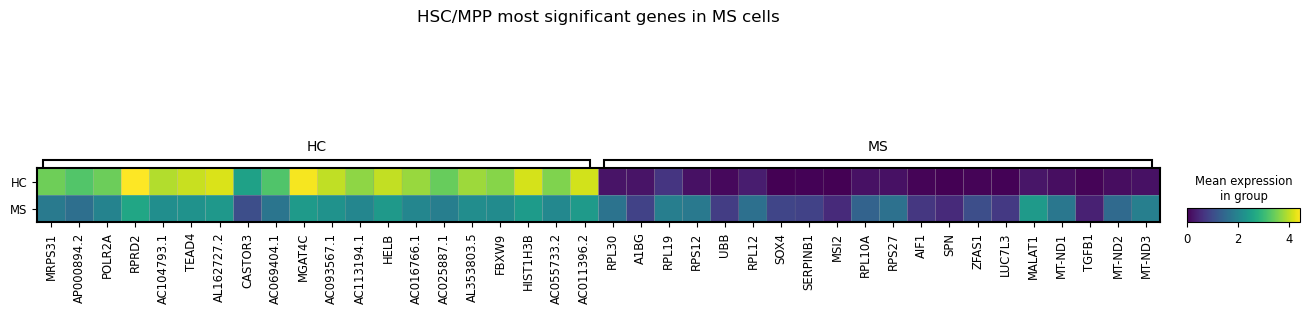

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



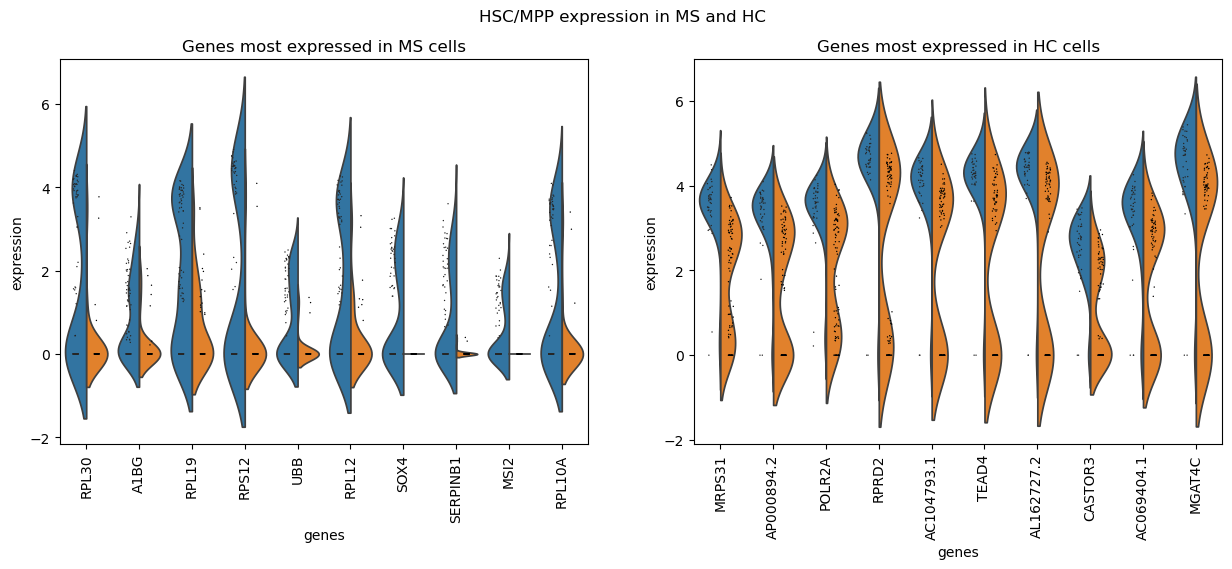

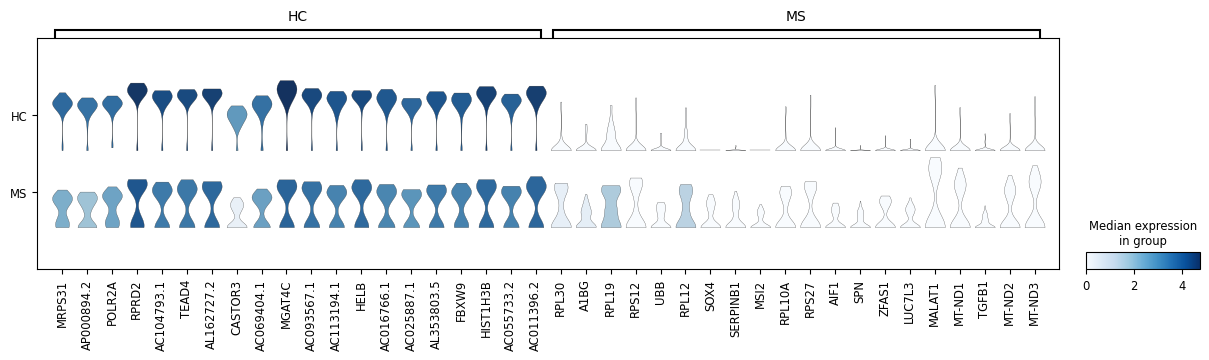

In [51]:
visualize_p_value_adj(adata_HSC_MPP, cell_type_name='HSC/MPP')
dotplots_and_ranking_most_significant_genes(adata_HSC_MPP, cell_type_name='HSC/MPP')
visualize_rank_genes_groups_violin(adata_HSC_MPP, cell_type_name='HSC/MPP')

In [52]:
sc.get.rank_genes_groups_df(adata_HSC_MPP, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  53.000000       53.000000  5.300000e+01  5.300000e+01
mean    5.357008        2.386326  1.550580e-06  1.278734e-03
std     0.708388        0.299978  2.735630e-06  2.025941e-03
min     4.361450        1.857111  3.644370e-13  1.382820e-08
25%     4.813790        2.149747  3.284303e-09  8.901401e-06
50%     5.173986        2.382655  2.291515e-07  3.220342e-04
75%     5.916718        2.601565  1.480945e-06  1.404825e-03
max     7.268153        3.221908  1.292033e-05  9.249983e-03

In [53]:
sc.get.rank_genes_groups_df(adata_HSC_MPP, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  53.000000       53.000000  5.300000e+01  5.300000e+01
mean   -5.357009       -2.386326  1.550580e-06  1.278734e-03
std     0.708388        0.299978  2.735630e-06  2.025941e-03
min    -7.268153       -3.221908  3.644370e-13  1.382820e-08
25%    -5.916718       -2.601565  3.284303e-09  8.901401e-06
50%    -5.173986       -2.382655  2.291515e-07  3.220342e-04
75%    -4.813790       -2.149747  1.480945e-06  1.404825e-03
max    -4.361450       -1.857111  1.292033e-05  9.249983e-03

### DC

In [54]:
if os.path.exists('write/DC.h5ad'):
    adata_DC = sc.read('write/DC.h5ad')
else:
    adata_DC = adata[adata.obs['cell_types_labels']=='DC']
    adata_DC = compute_rank_genes_group(adata_DC)
    adata_DC.write('write/DC.h5ad')
adata_DC

AnnData object with n_obs × n_vars = 269 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'rank_genes_groups', 't-test', 'wilcoxon'

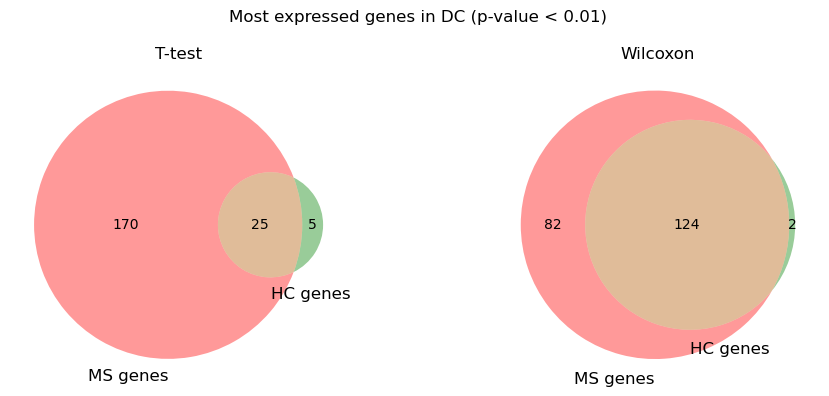

In [55]:
visualize_venn_diagram_ttest_vs_wilcoxon(adata_DC, cell_type_name='DC')

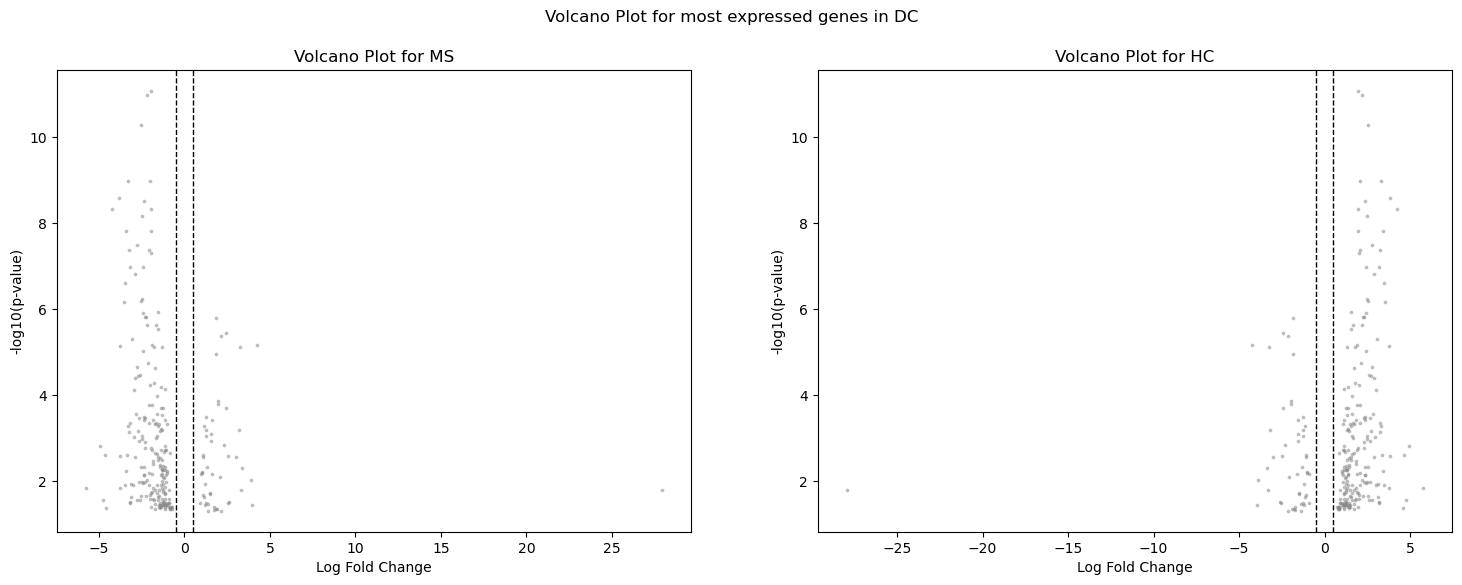

In [56]:
volcano_plot(adata_DC, cell_type_name='DC')

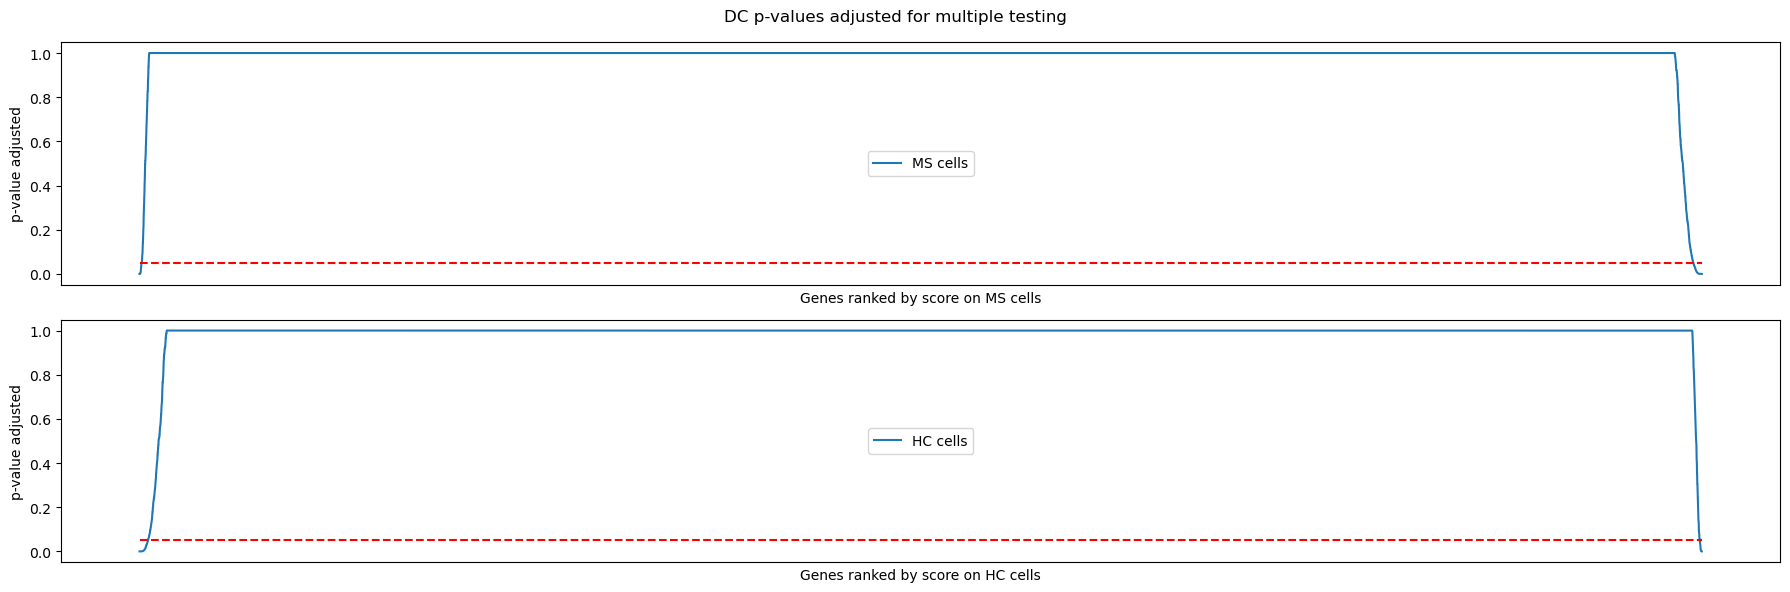

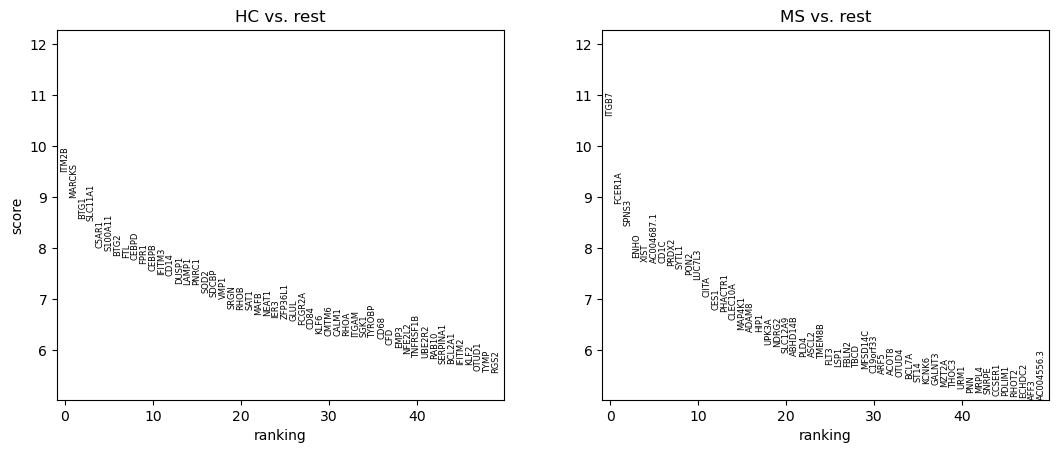

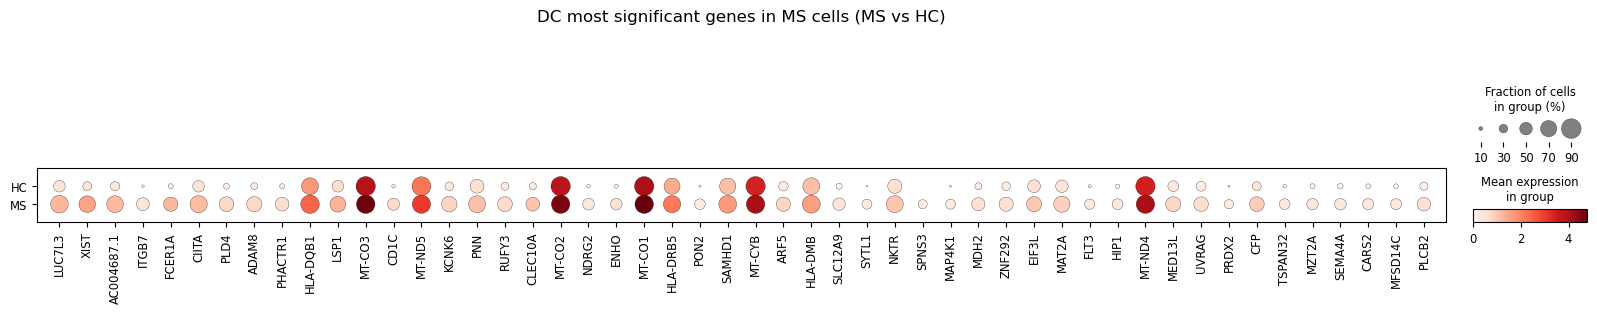

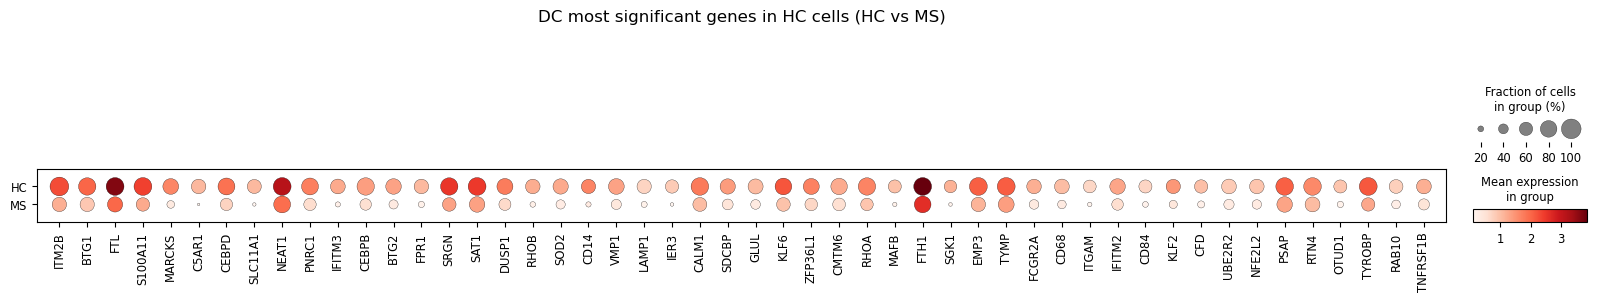

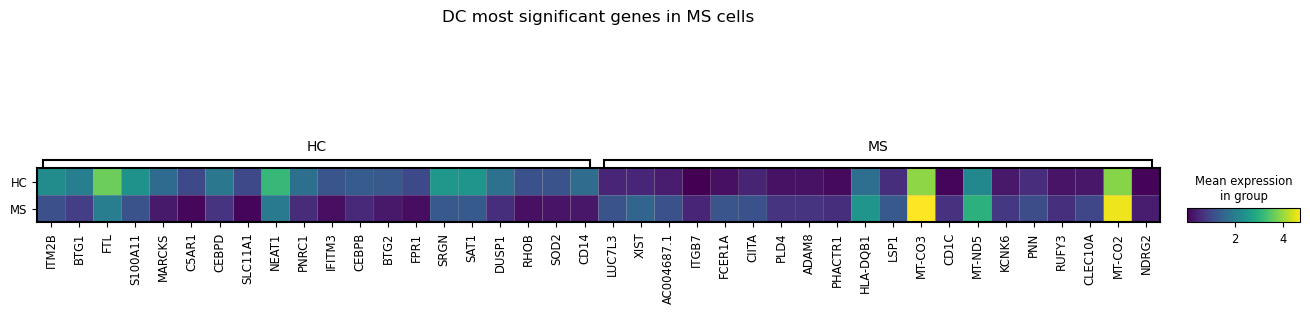

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning:

FixedFormatter should only be used together with FixedLocator



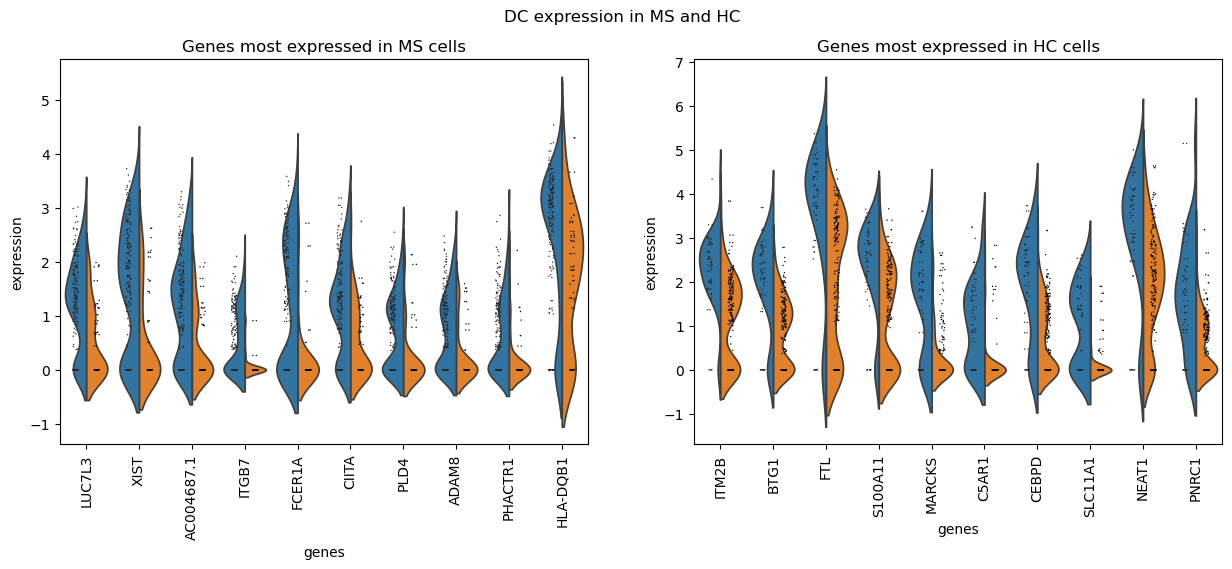

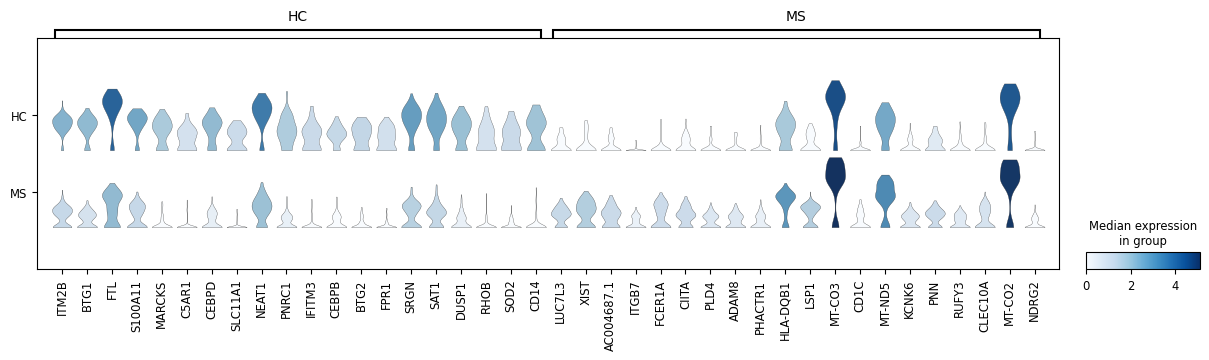

In [57]:
visualize_p_value_adj(adata_DC, cell_type_name='DC')
dotplots_and_ranking_most_significant_genes(adata_DC, cell_type_name='DC')
visualize_rank_genes_groups_violin(adata_DC, cell_type_name='DC')

In [58]:
sc.get.rank_genes_groups_df(adata_DC, group='HC', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  156.000000      156.000000  1.560000e+02  1.560000e+02
mean     3.303724        1.319782  6.414282e-06  1.854753e-03
std      4.096829        1.831893  9.762552e-06  2.520681e-03
min     -6.081596       -4.242379  2.162831e-16  8.206647e-12
25%      4.211678        1.133298  8.158777e-09  7.770479e-06
50%      4.701186        1.703529  1.040072e-06  5.025690e-04
75%      5.500347        2.421486  8.798799e-06  2.835406e-03
max      8.212692        4.911983  3.957097e-05  9.624876e-03

In [59]:
sc.get.rank_genes_groups_df(adata_DC, group='MS', key='wilcoxon', pval_cutoff=0.01).describe()

scores  logfoldchanges         pvals     pvals_adj
count  156.000000      156.000000  1.560000e+02  1.560000e+02
mean    -3.303724       -1.319782  6.414282e-06  1.854753e-03
std      4.096829        1.831893  9.762552e-06  2.520681e-03
min     -8.212692       -4.911983  2.162831e-16  8.206647e-12
25%     -5.500347       -2.421486  8.158777e-09  7.770479e-06
50%     -4.701186       -1.703529  1.040072e-06  5.025690e-04
75%     -4.211678       -1.133298  8.798799e-06  2.835406e-03
max      6.081596        4.242379  3.957097e-05  9.624876e-03